# Analisi Predittiva di Serie Numeriche

Questo notebook si propone come riassunto della nostra esperienza nel tirocinio sulla previsione di serie numeriche temporali.
Il tirocinio è stato diviso in due fasi, ciascuna della quali corrisponde a un dataset differente:

- previsioni su "negozio Albignasego"
- previsioni su "M5 Competition"

Nella prima fase ciascuno di noi ha scelto in totale autonomia che metodo utilizzare per studiare e successivamente prevedere
le serie temporali che ci sono state fornite, mentre la seconda è stata un lavoro di gruppo in cui abbiamo elaborato una soluzione comune per il problema che ci è stato proposto.

## Confronto tra modelli

Nel primo lavoro ci è stato fornito un insieme di dati riguardanti le vendite nel periodo 23/03/2013-29/09/2019 di un negozio di capi di abbigliamento. Abbiamo deciso di concentrarci unicamente sulla serie delle maglie in quanto il comportamento delle serie degli altri capi di abbiagliamento risultava analogo. Abbiamo diviso la serie nei due set di validazione (contenente l'80% delle osservazioni) e uno di validazione (contenente il 20% da confrontare con i risultati delle previsioni) e successivamente ci siamo concentrati sull'applicazione di modelli per le previsioni con lo scopo di trovare quelli che fornissero i risultati migliori.

### Studio della serie

Per lo studio della serie ci siamo serviti di una serie di librerie che potessero fornire una serie di strumenti per estrarre o determinare le sue caratteristiche, oltre alle librerie per la manipolazione dei dati.

In [2]:
import math
import itertools #realizzazione combinazioni per testare tutti i possibili ordini
import numpy as np #strumenti matematici (metriche d'errore etc.)
import pandas as pd #gestione serie temporali/dataframe
import matplotlib.pyplot as plt #stampa dei grafici
import datetime as dt #manipolazione date
from statsmodels.tsa.arima_model import ARIMA #modello ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose #decomposizione serie in componenti
from statsmodels.tsa.stattools import adfuller #metrica Dickey-Fuller per stazionarietà
from statsmodels.tsa.stattools import kpss #metrica kpss per trend stazionarietà
from statsmodels.tsa.stattools import acf, pacf #per la realizzazione dei grafici di autocorrelazione e autorcorrelazione parziale
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #modello Simple ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing #modello  ETS
from sklearn.metrics import mean_squared_error #metrica di errore MSE

Per studiare la stagionalità della serie abbiamo utilizzato i grafici di autocorrelazione e autocorrelazione parziale. 
I grafici di autocorrelazione forniscono i valori di autocorrelazione di una serie con i suoi valori spostati di un certo lag, descrivendo quindi la relazione tra i valori della serie in un certo momento siano in relazione con i valori passati. La funzione di autocorrelazione non fa distinzione tra le componenti della serie.
I grafici di autocorrelazione parziale invece trattano la correlazione tra i residui e residui spostati di un certo lag, mettendo in evidenza informazioni nascoste ancora presenti nei residui.
I picchi più alti rappresentano i valori di stagionalità più interessanti da studiare.

In [3]:
def ac_pac_function(timeseries, lags=40):

    """
    Parameters
    ----------
    timeseries : pd.Series
        La serie su cui calcolare le funzioni di auto-correlazione e autocorrelazione parziale
    lags : int, optional
        Il lag massimo rappresentato nel grafico. The default is 20.

    Returns
    -------
    None.
    """

    lag_acf = acf(timeseries, nlags=lags, fft=True)
    lag_pacf = pacf(timeseries, nlags=lags, method='ols')
    
    plt.figure(figsize=(40, 20), dpi=80)
    
    #Plot ACF:
    
    plt.subplot(211)     
    plt.plot(lag_acf, color = 'orange')
    
    #Delimito i tre intervalli
    
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.title('Autocorrelation function')
    
    #Plot PACF
    
    plt.subplot(212)
    plt.plot(lag_pacf, color = 'orange')
    
    #Delimito i tre intervalli
    
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='black')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [4]:
def test_stationarity(timeseries):    
    
    """
    Parameters
    ----------
    timeseries : pd.Series
        La serie di cui calcolare la stazionarietà con il metodo Dickey-Fuller
    Returns
    -------
    None.
    """
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    # Valori critici
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    print('\n')
    if(dfoutput['Test Statistic']<dfoutput['Critical Value (1%)']):
        print("La serie è stazionaria (test Dickey-Fuller)")
    else:
        print("La serie non è stazionaria (test Dickey-Fuller)")

In [5]:
# Costanti per grandezza testo

SMALL_SIZE = 28 
MEDIUM_SIZE = 30 
BIGGER_SIZE = 32 

# Inizializzazione caratteristiche base dei PLOT

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes 
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title 
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels 
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels 
plt.rc('legend', fontsize=SMALL_SIZE)    # fontsize of the legend
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# COLORI

TSC = 'black'   # training set
VSC = 'black'   # validation set
FC = 'red'      # previsioni
MRC = 'green'   # model results
OLC = 'orange'  # other lines

# STAGIONI

year = 365 # giorni
week = 7
half_year = 183

# STAGIONE SELEZIONATA PER ESECUZIONE 

season = year

# caricamento insieme dati e verifica tipo delle colonne (solo per controllo)
# L'insieme di dati contiene la data e il numero di capi di abbigliamento venduti
# in quel giorno (per tipo).
# Faccio in modo che la data sia letta per ottenere una serie temporale

dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./NEGOZIO_ABBIGLIAMENTO/Dati_Albignasego/Whole period.csv', index_col=0, date_parser=dateparse)

# usiamo solo la serie maglie. Il procedimento si può ripetere con ciascun capo...

ts = data['MAGLIE']

In [6]:
# Costanti per spezzare la serie temporale sempre nello stesso punto

START_TRAIN = ts.index[0]
END_TRAIN = ts.index[int(len(ts) * 0.8)]
START_VALID = ts.index[int(len(ts)*0.8)+1]
END_VALID = ts.index[int(len(ts))-1]

# Se si vuole togliere il 29 febbraio 2016 per avere solo anni di 365 giorni. 
"""ts = ts.drop(labels=[pd.Timestamp('2016-02-29')])"""

train = ts[pd.date_range(start=START_TRAIN, end=END_TRAIN, freq='D')]
valid = ts[pd.date_range(start=START_VALID, end=END_VALID, freq='D')]

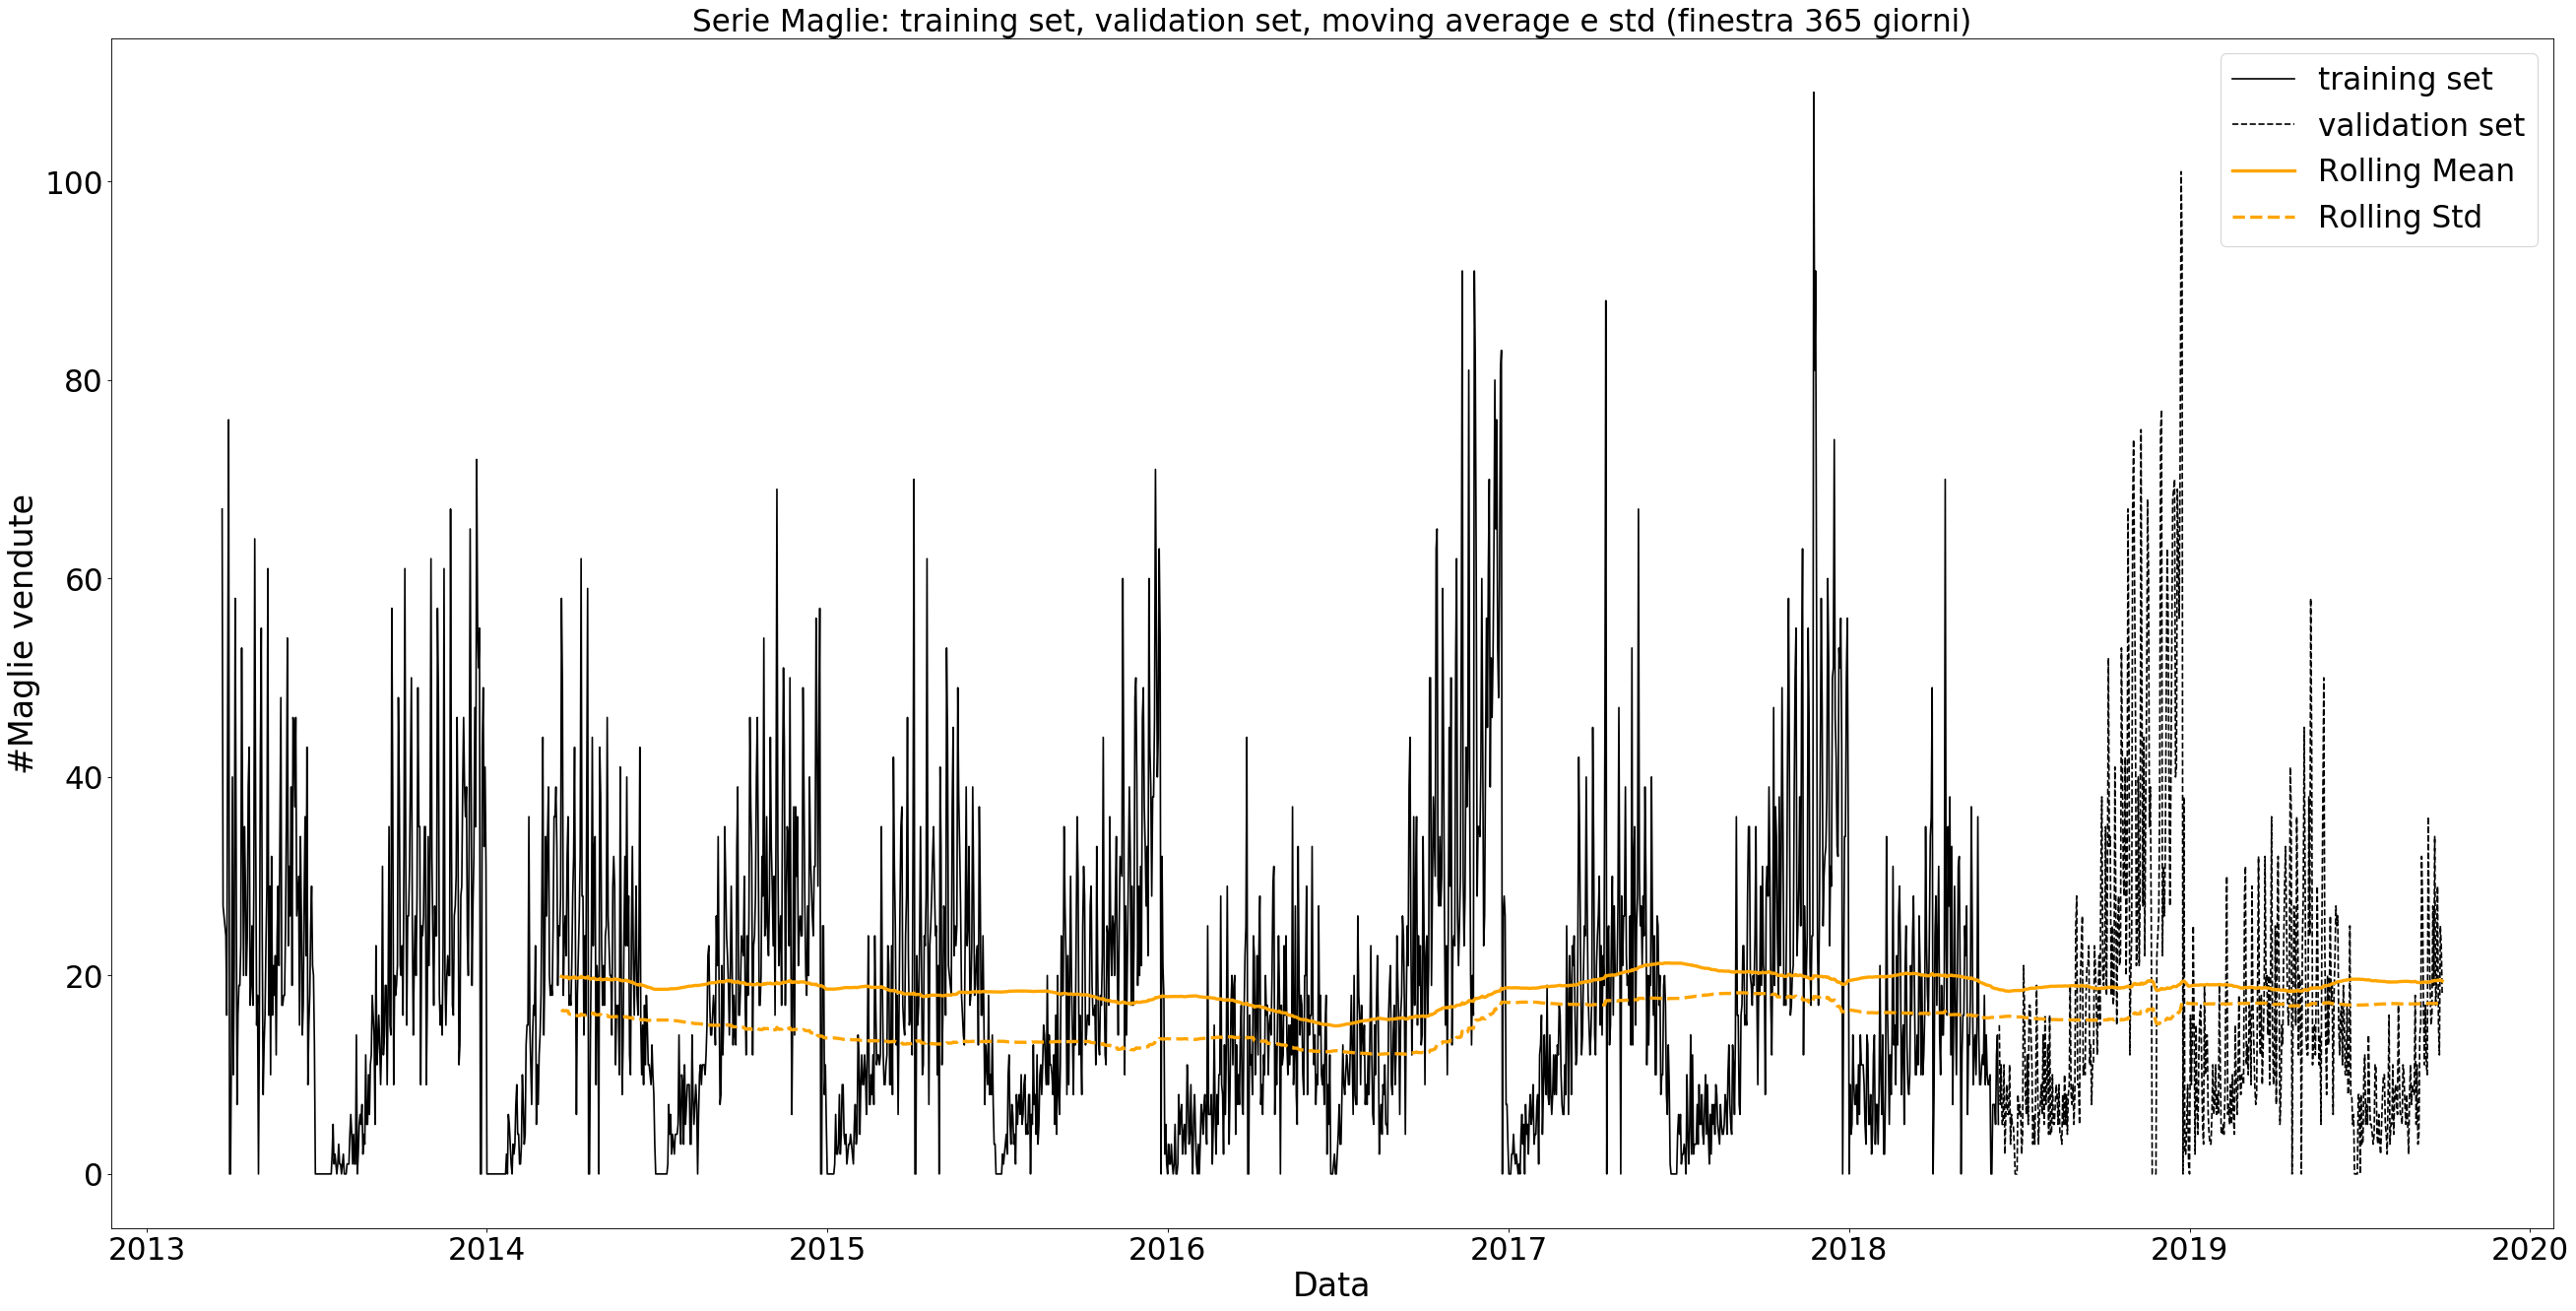

In [4]:
# plot std e media con finestra di un anno

rolmean = ts.rolling(window=year).mean()
rolstd = ts.rolling(window=year).std()

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 365 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

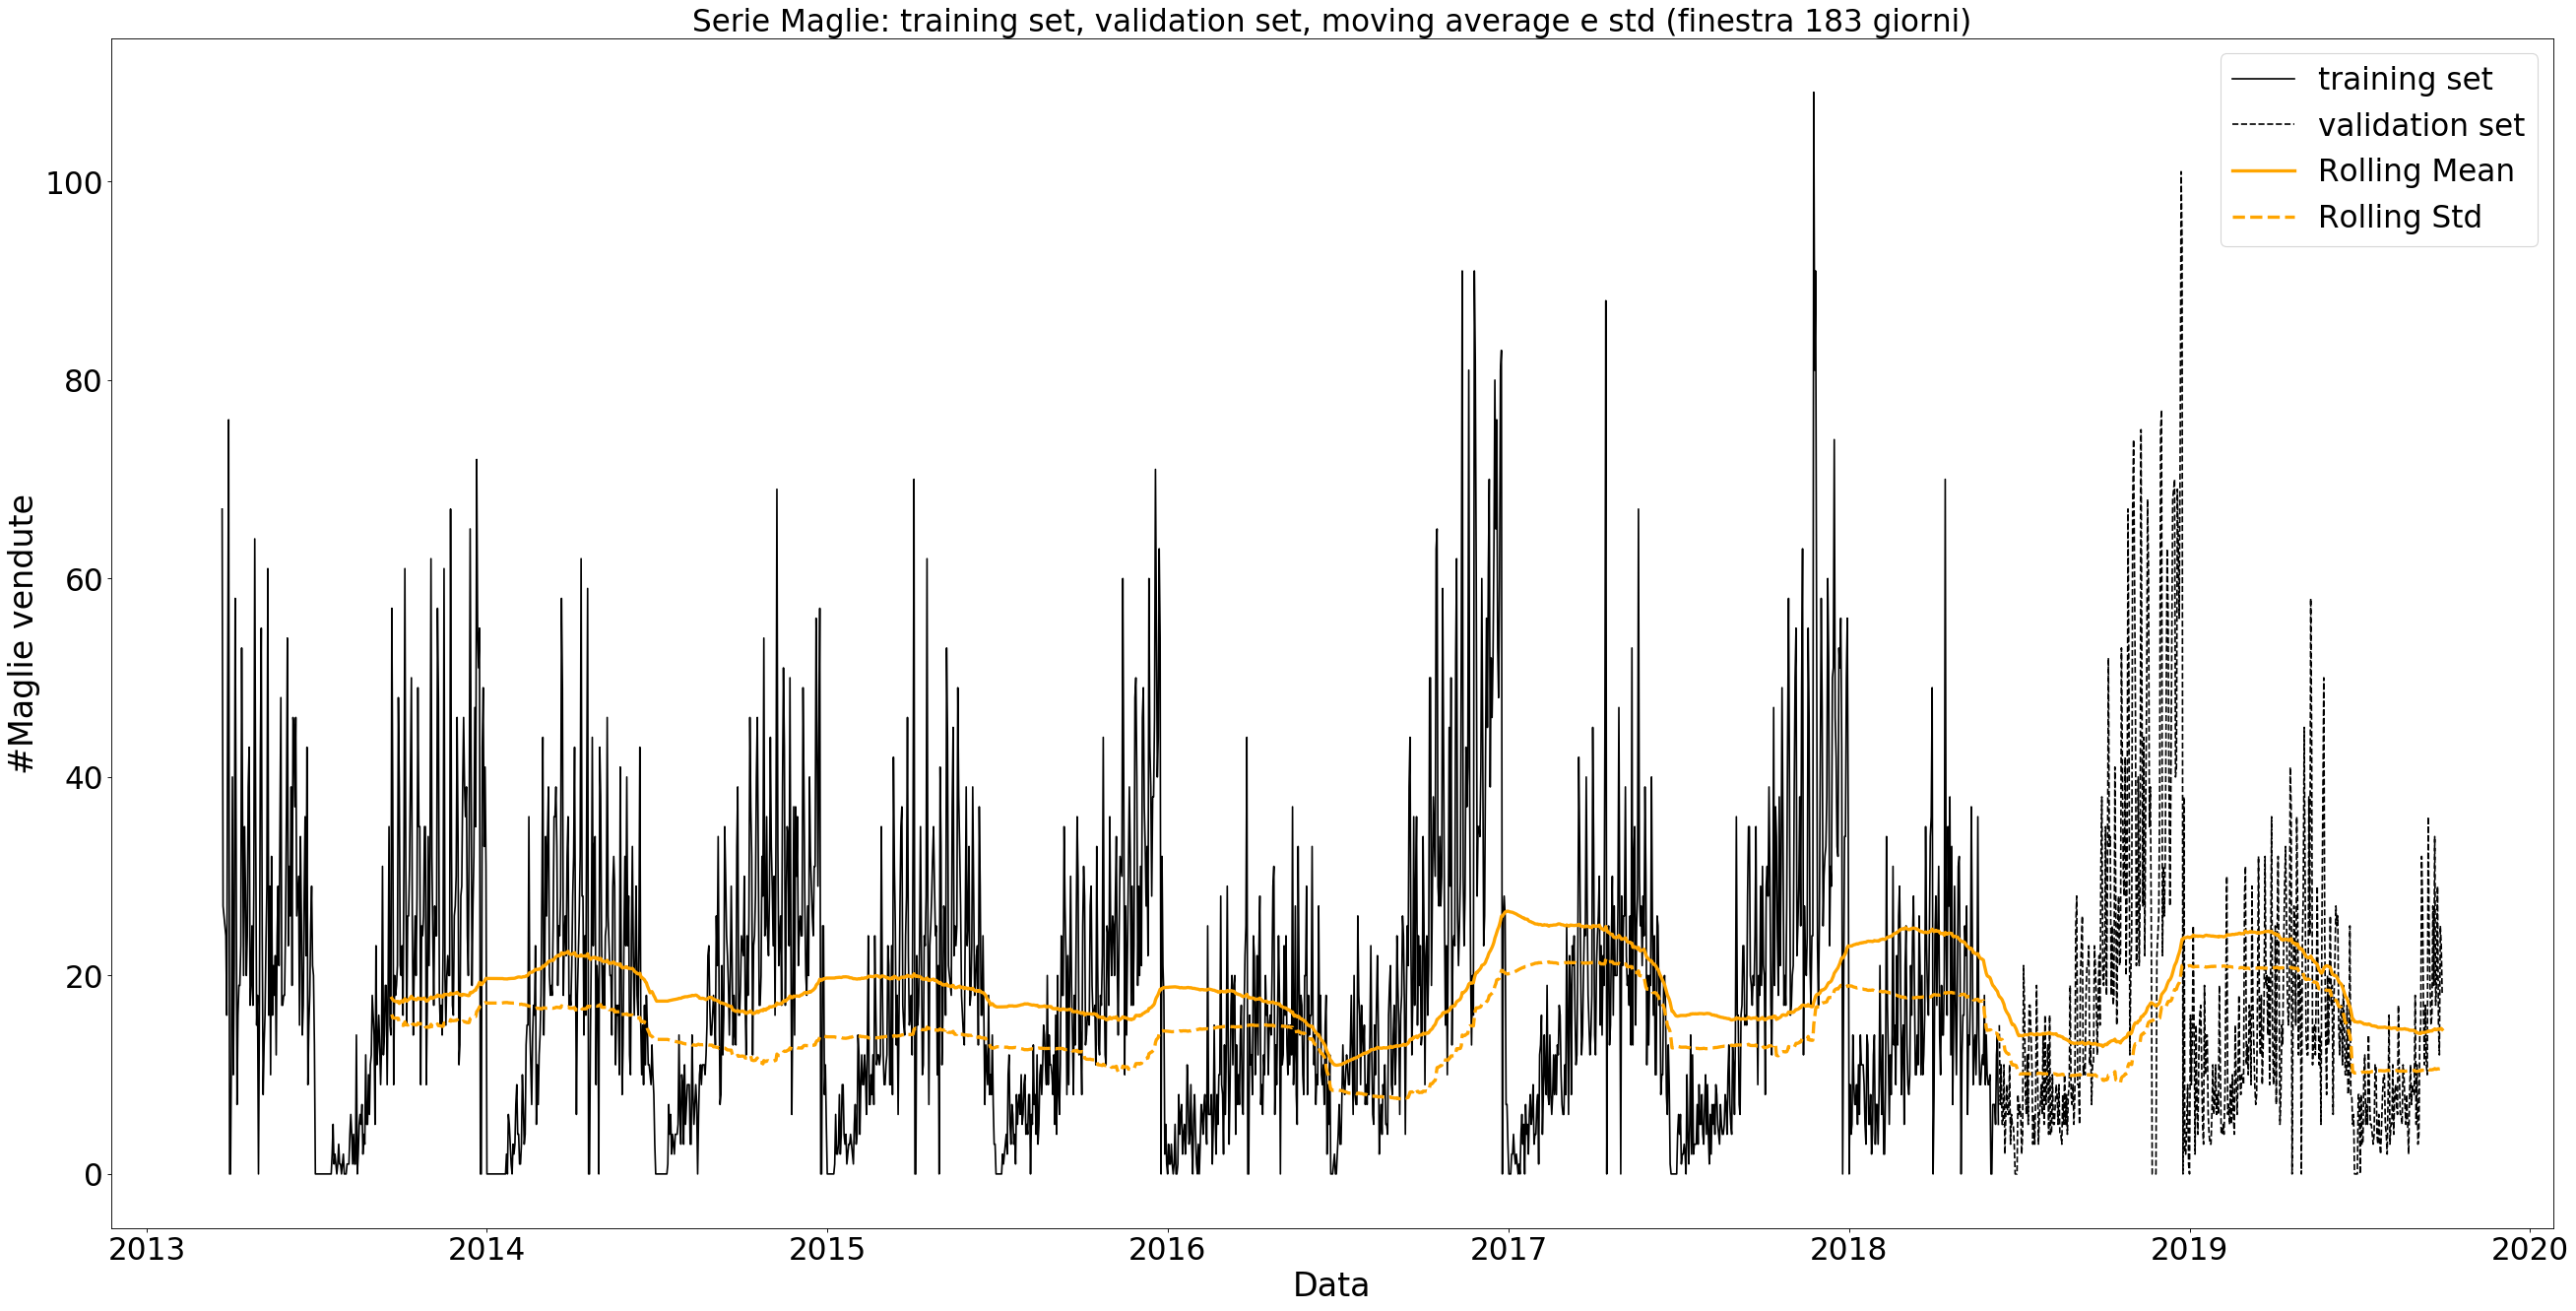

In [6]:
# plot std e media con finestra di metà anno

rolmean = ts.rolling(window=half_year).mean()
rolstd = ts.rolling(window=half_year).std()

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 183 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

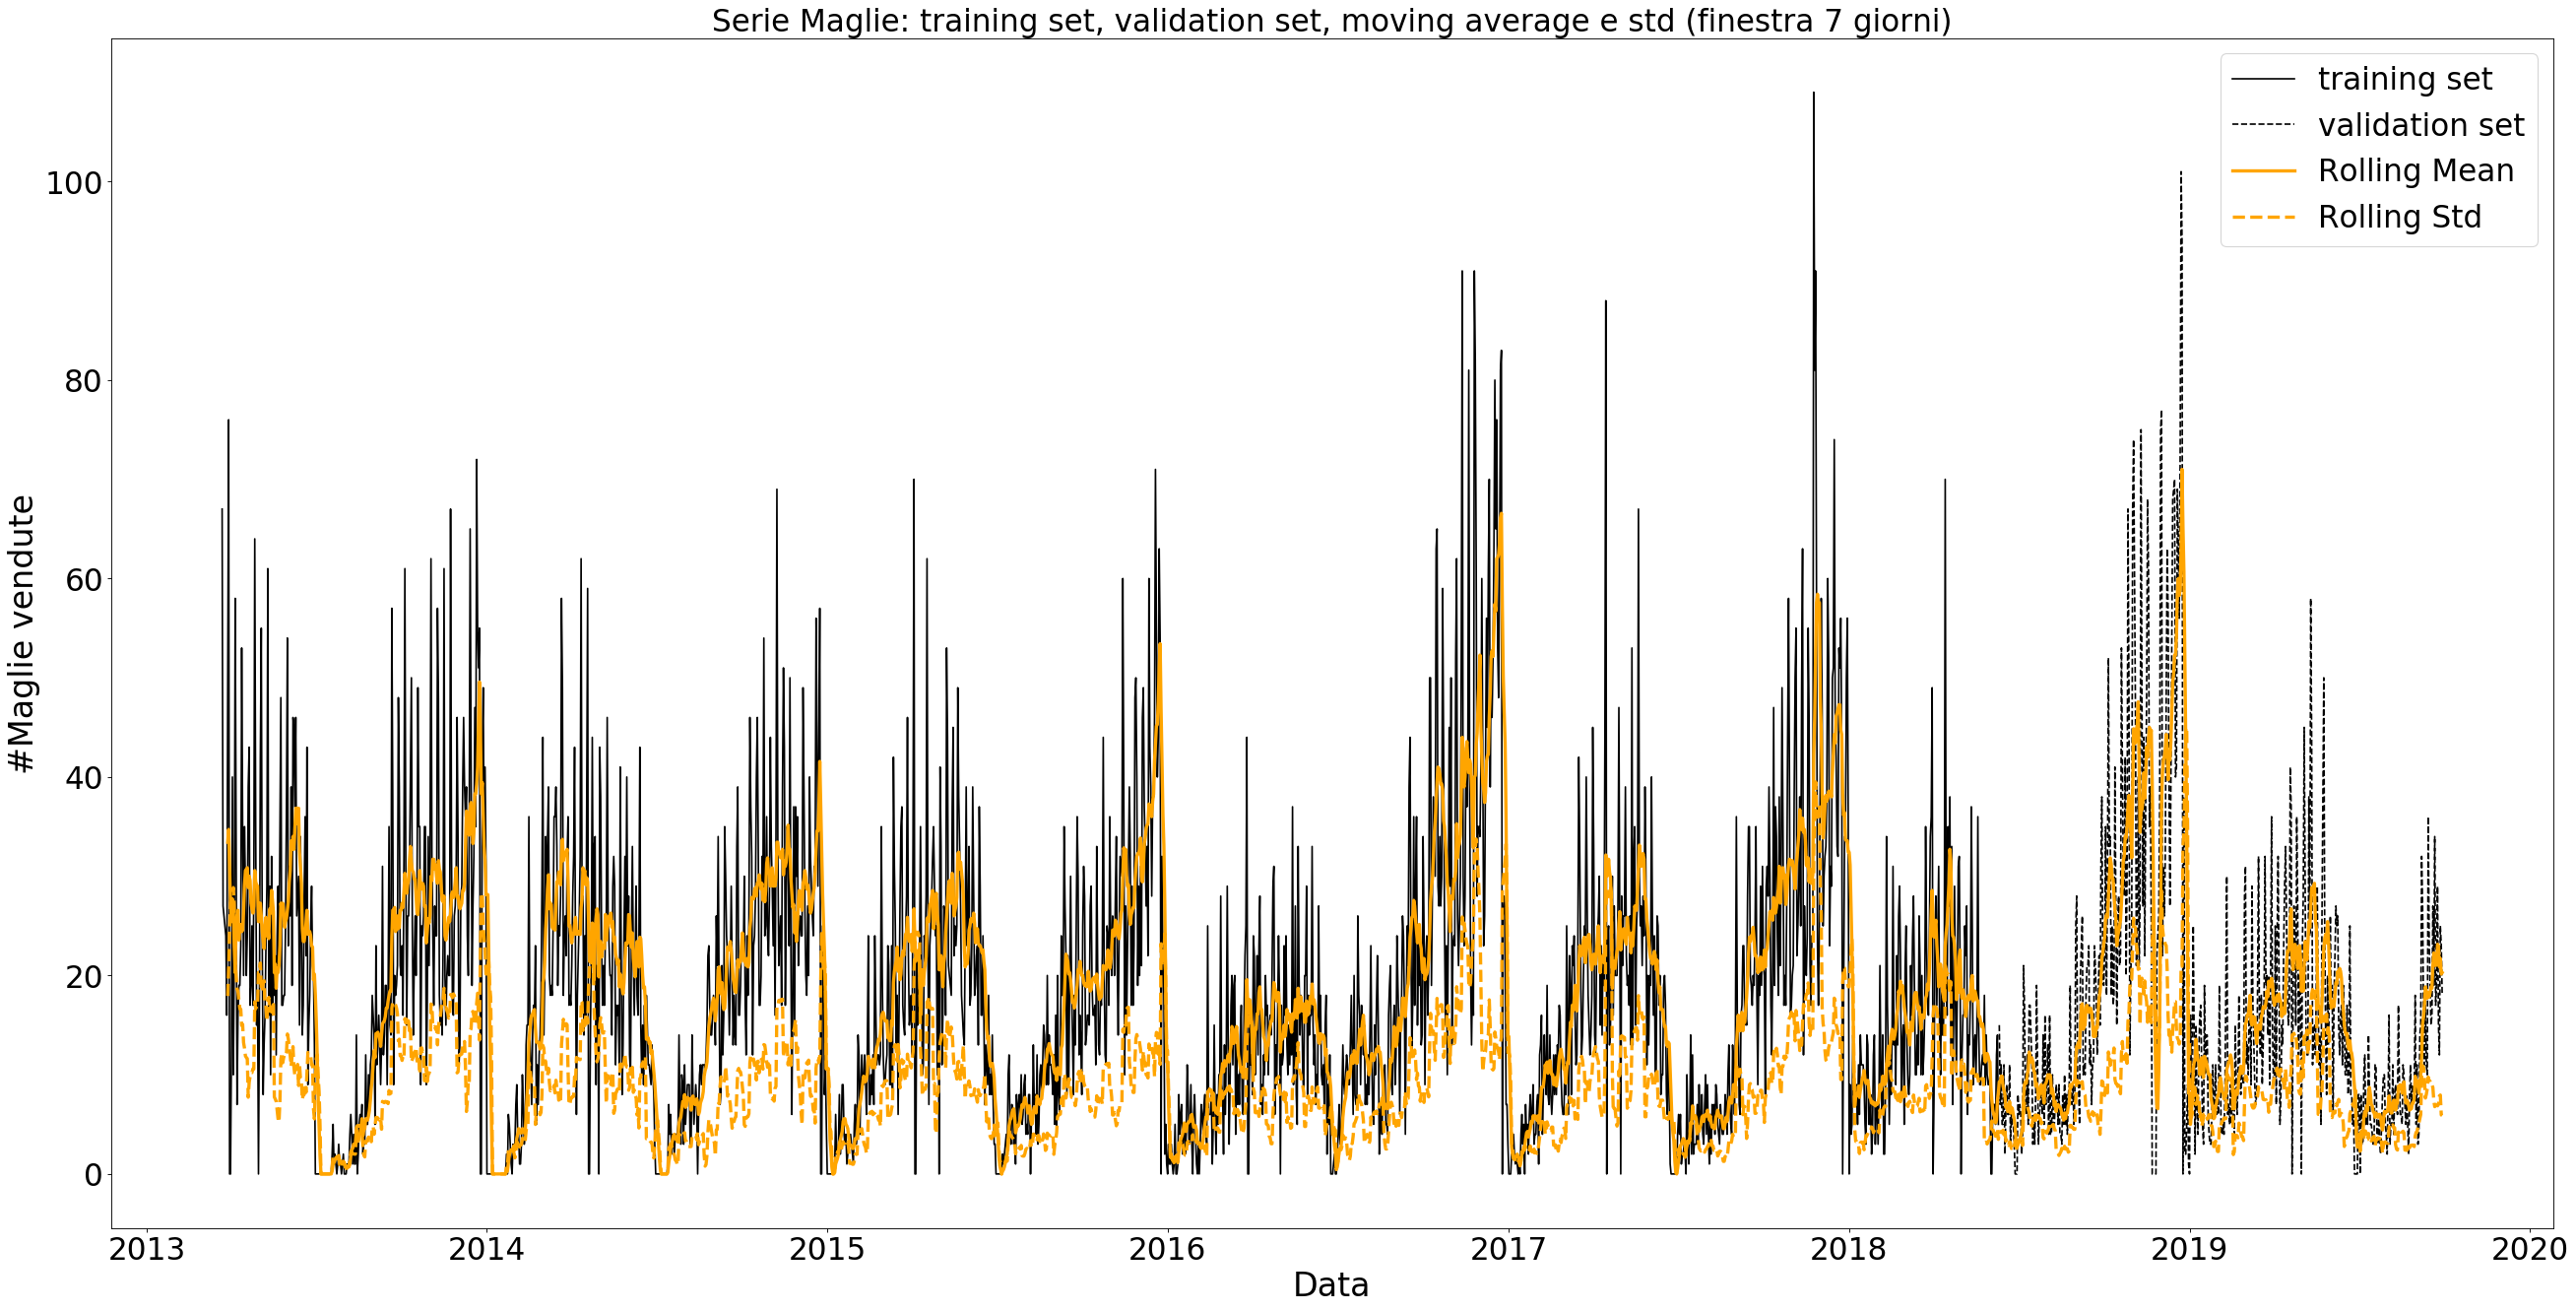

In [7]:
# plot std e media con finestra settimanale

rolmean = ts.rolling(window=week).mean()
rolstd = ts.rolling(window=week).std()

plt.figure(figsize=(40, 20), dpi=80)
plt.title('Serie Maglie: training set, validation set, moving average e std (finestra 7 giorni)')
plt.ylabel('#Maglie vendute')
plt.xlabel('Data')
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(rolmean, color=OLC, label='Rolling Mean',  linewidth=3)
plt.plot(rolstd, color=OLC, label='Rolling Std', linestyle = '--',  linewidth=3)
plt.legend(loc='best')
plt.show(block=False)

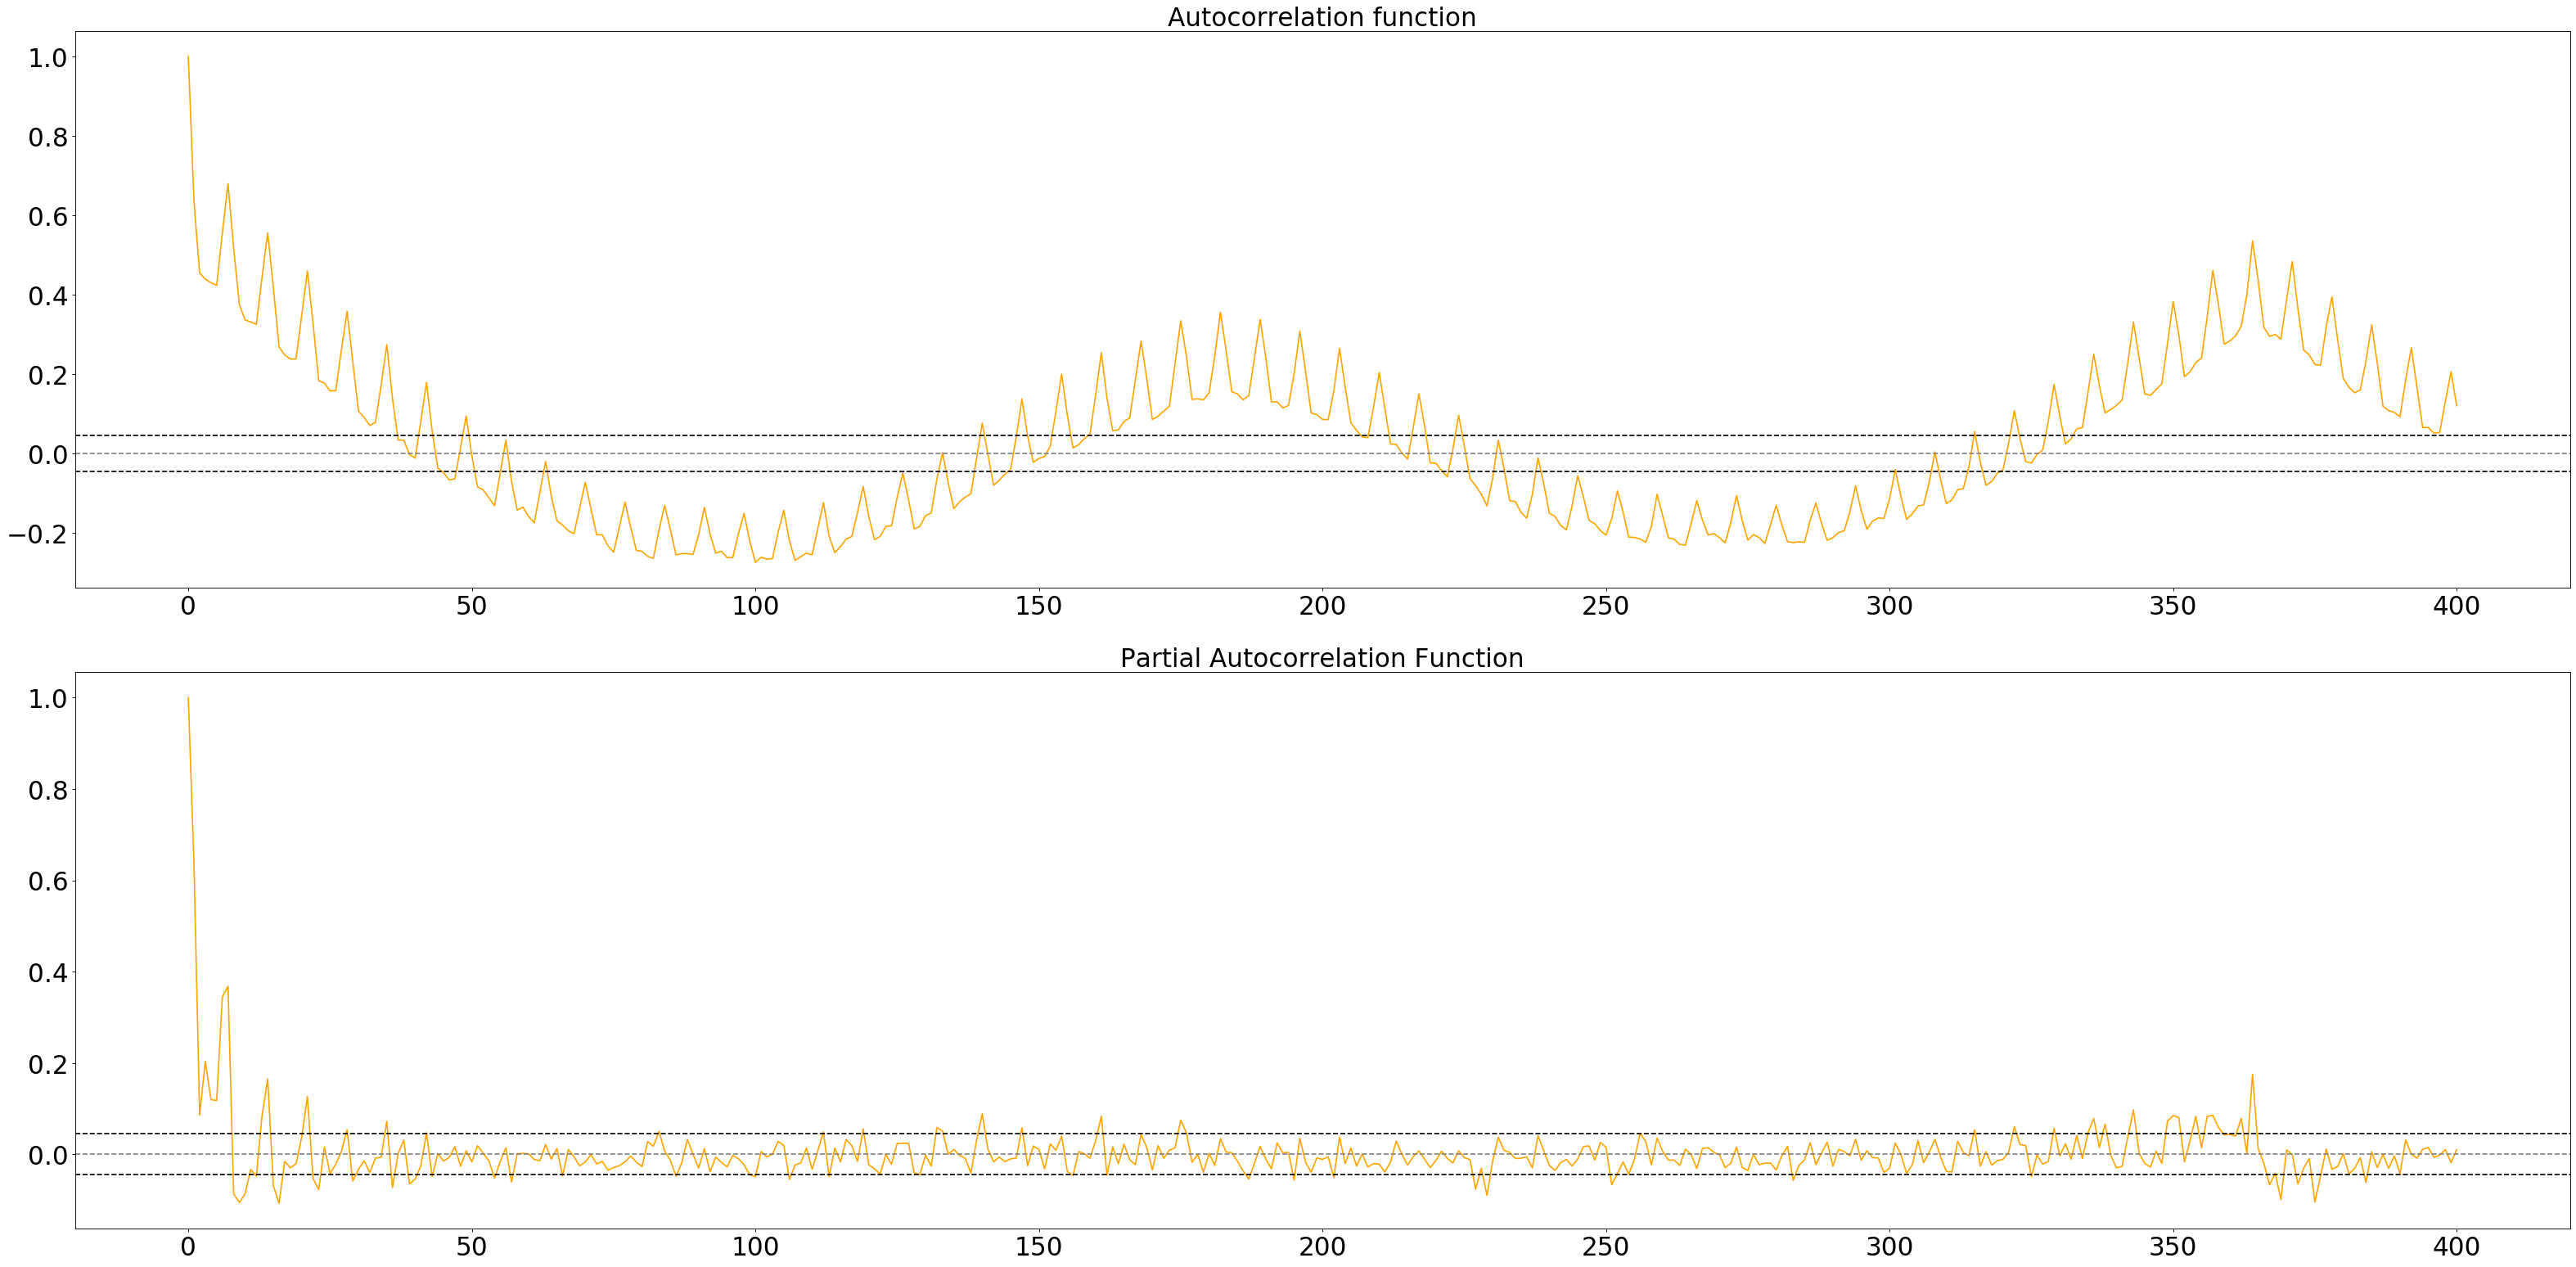

In [8]:
ac_pac_function(train, lags = 400)

Giunti a questo punto calcolo il grado di forza della stagionalità per determinare se sia necessario o meno applicare una differenziazione stagionale. Quest'ultima è consigliata solo se il grado di forza risulta maggiore di 0.64

La forza della stagionalità di periodo 365 è: 0.5495909566239753


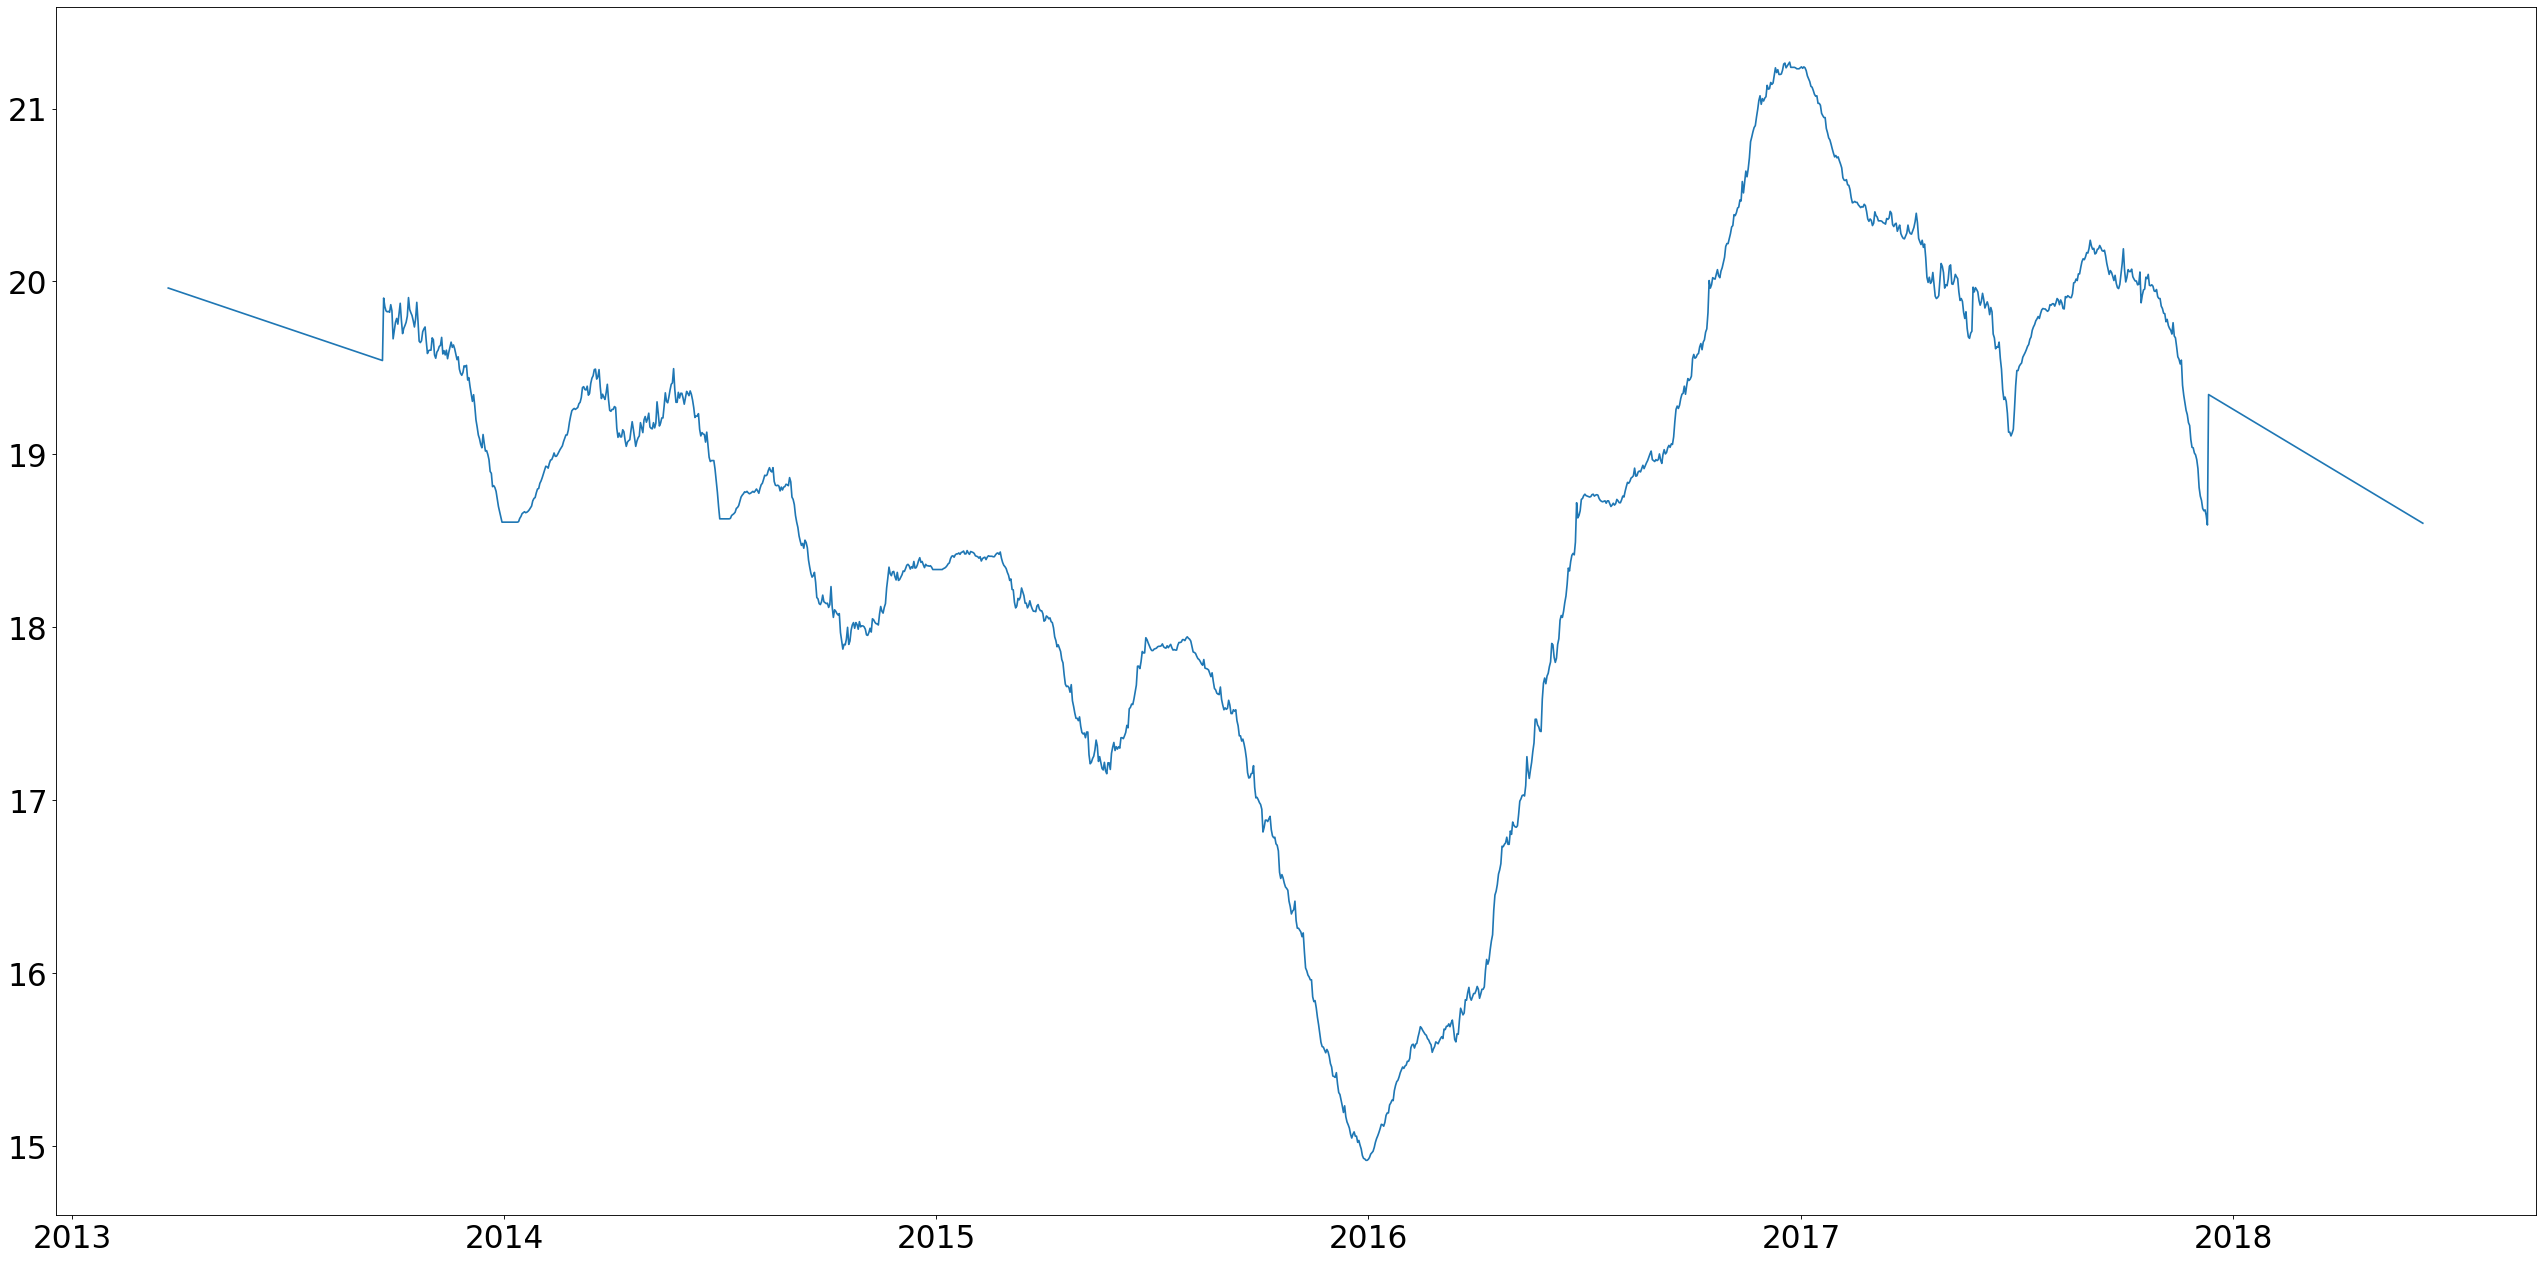

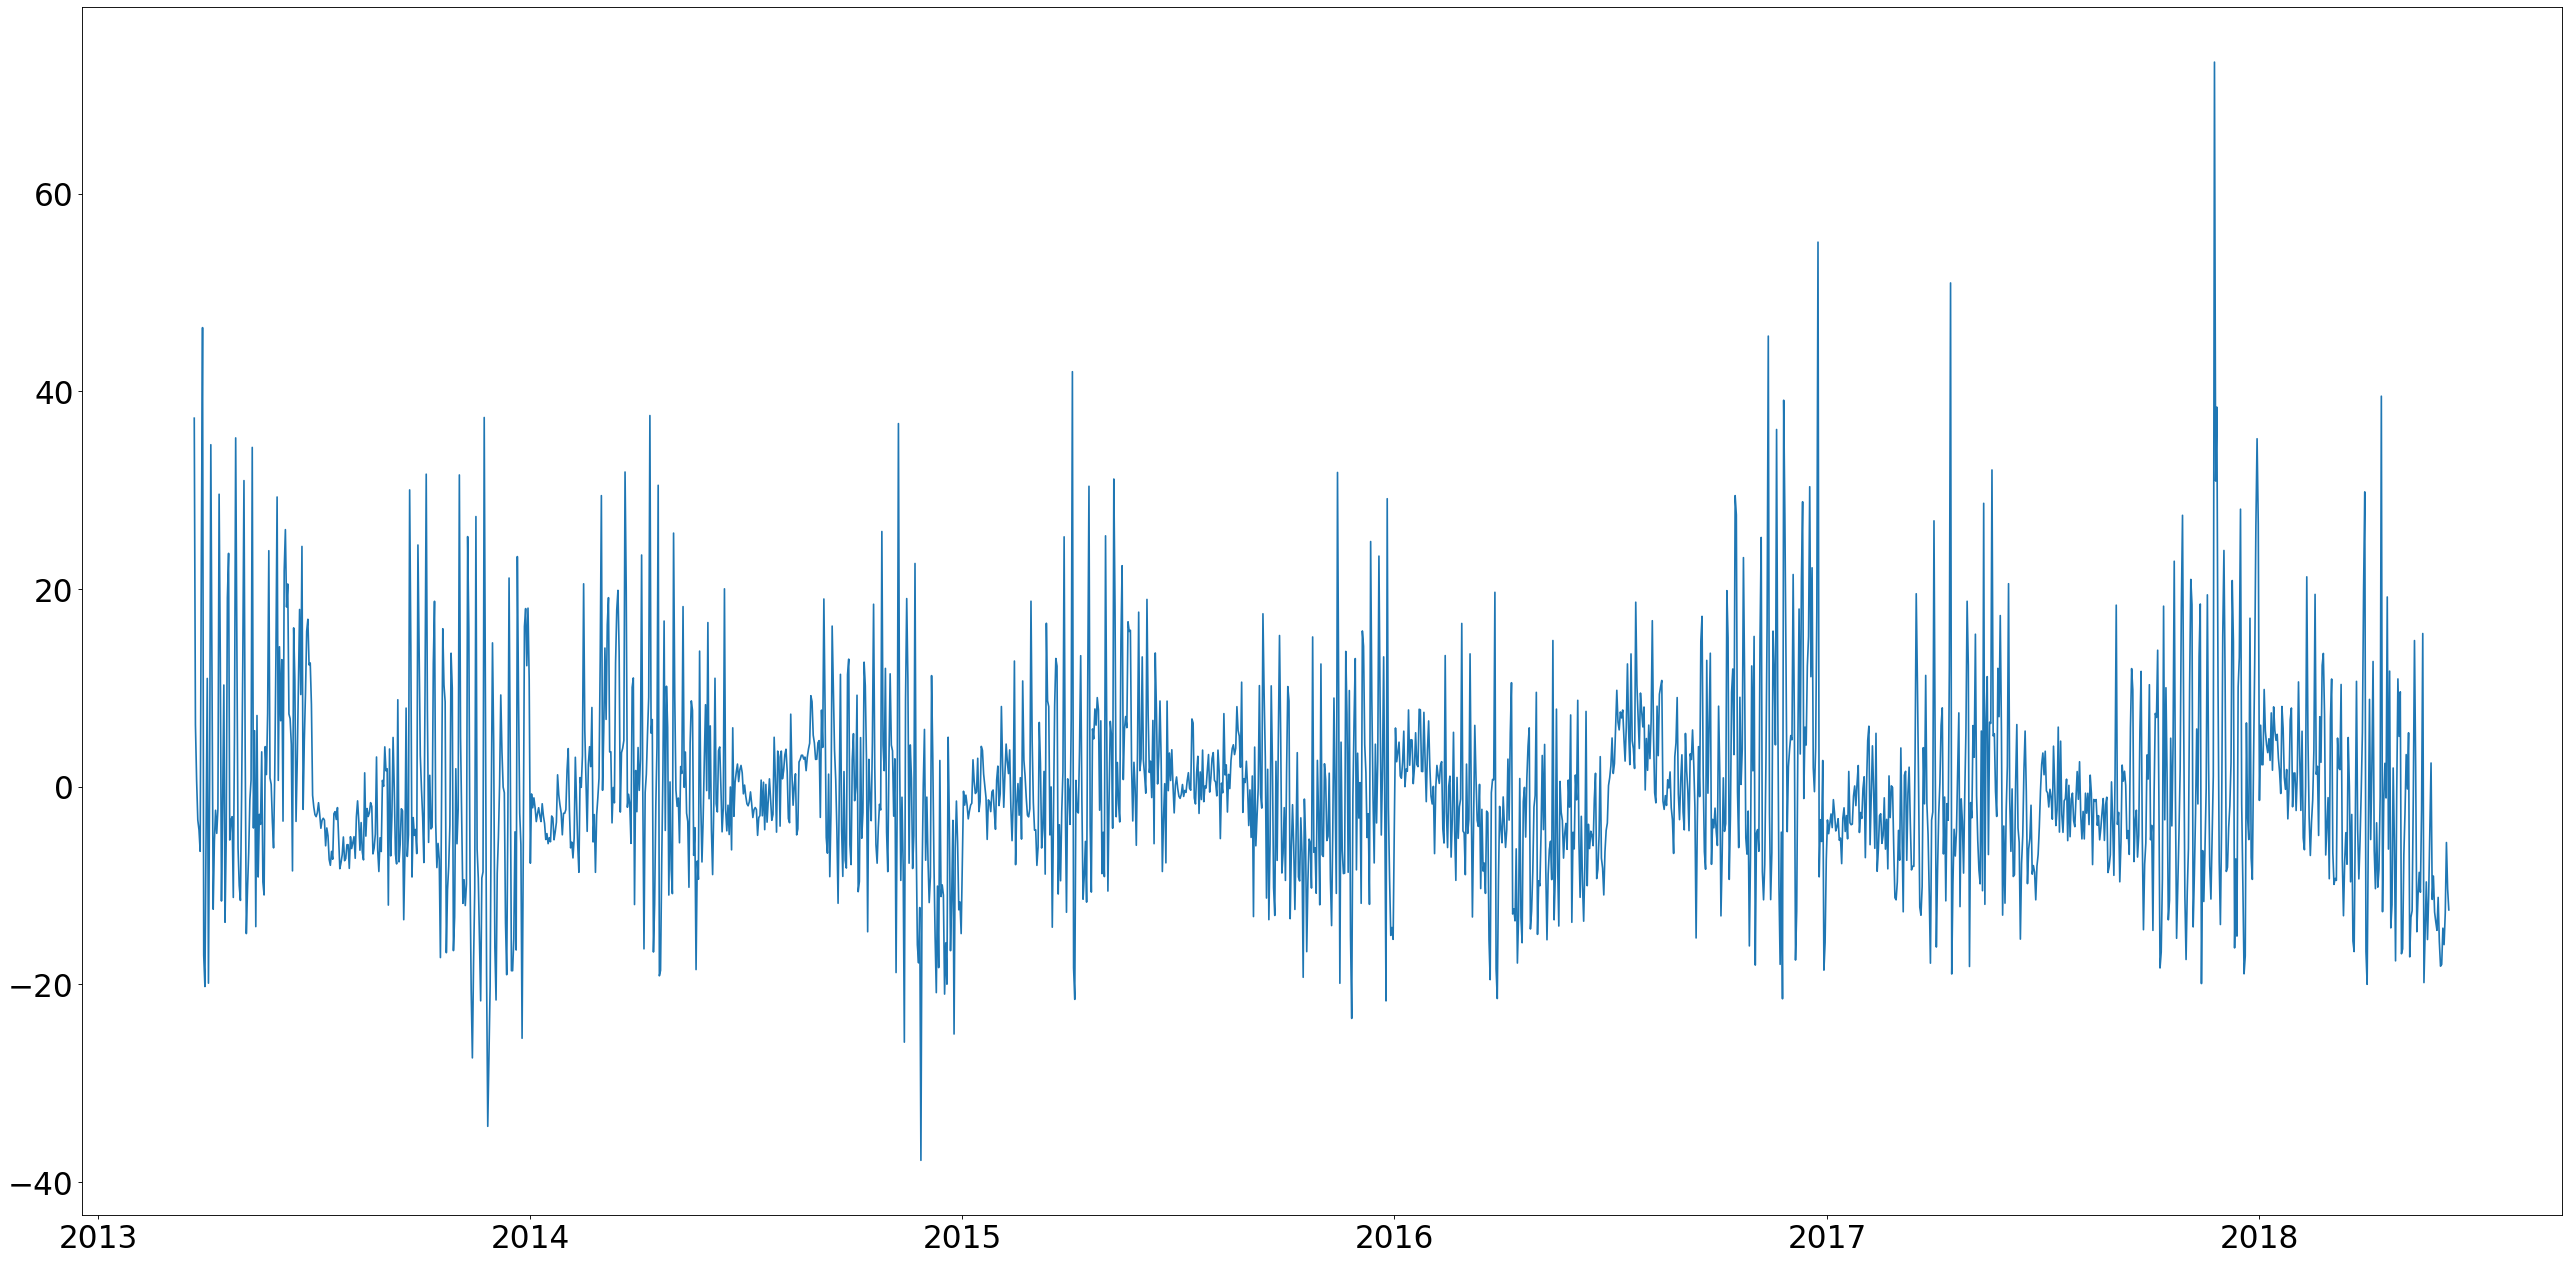

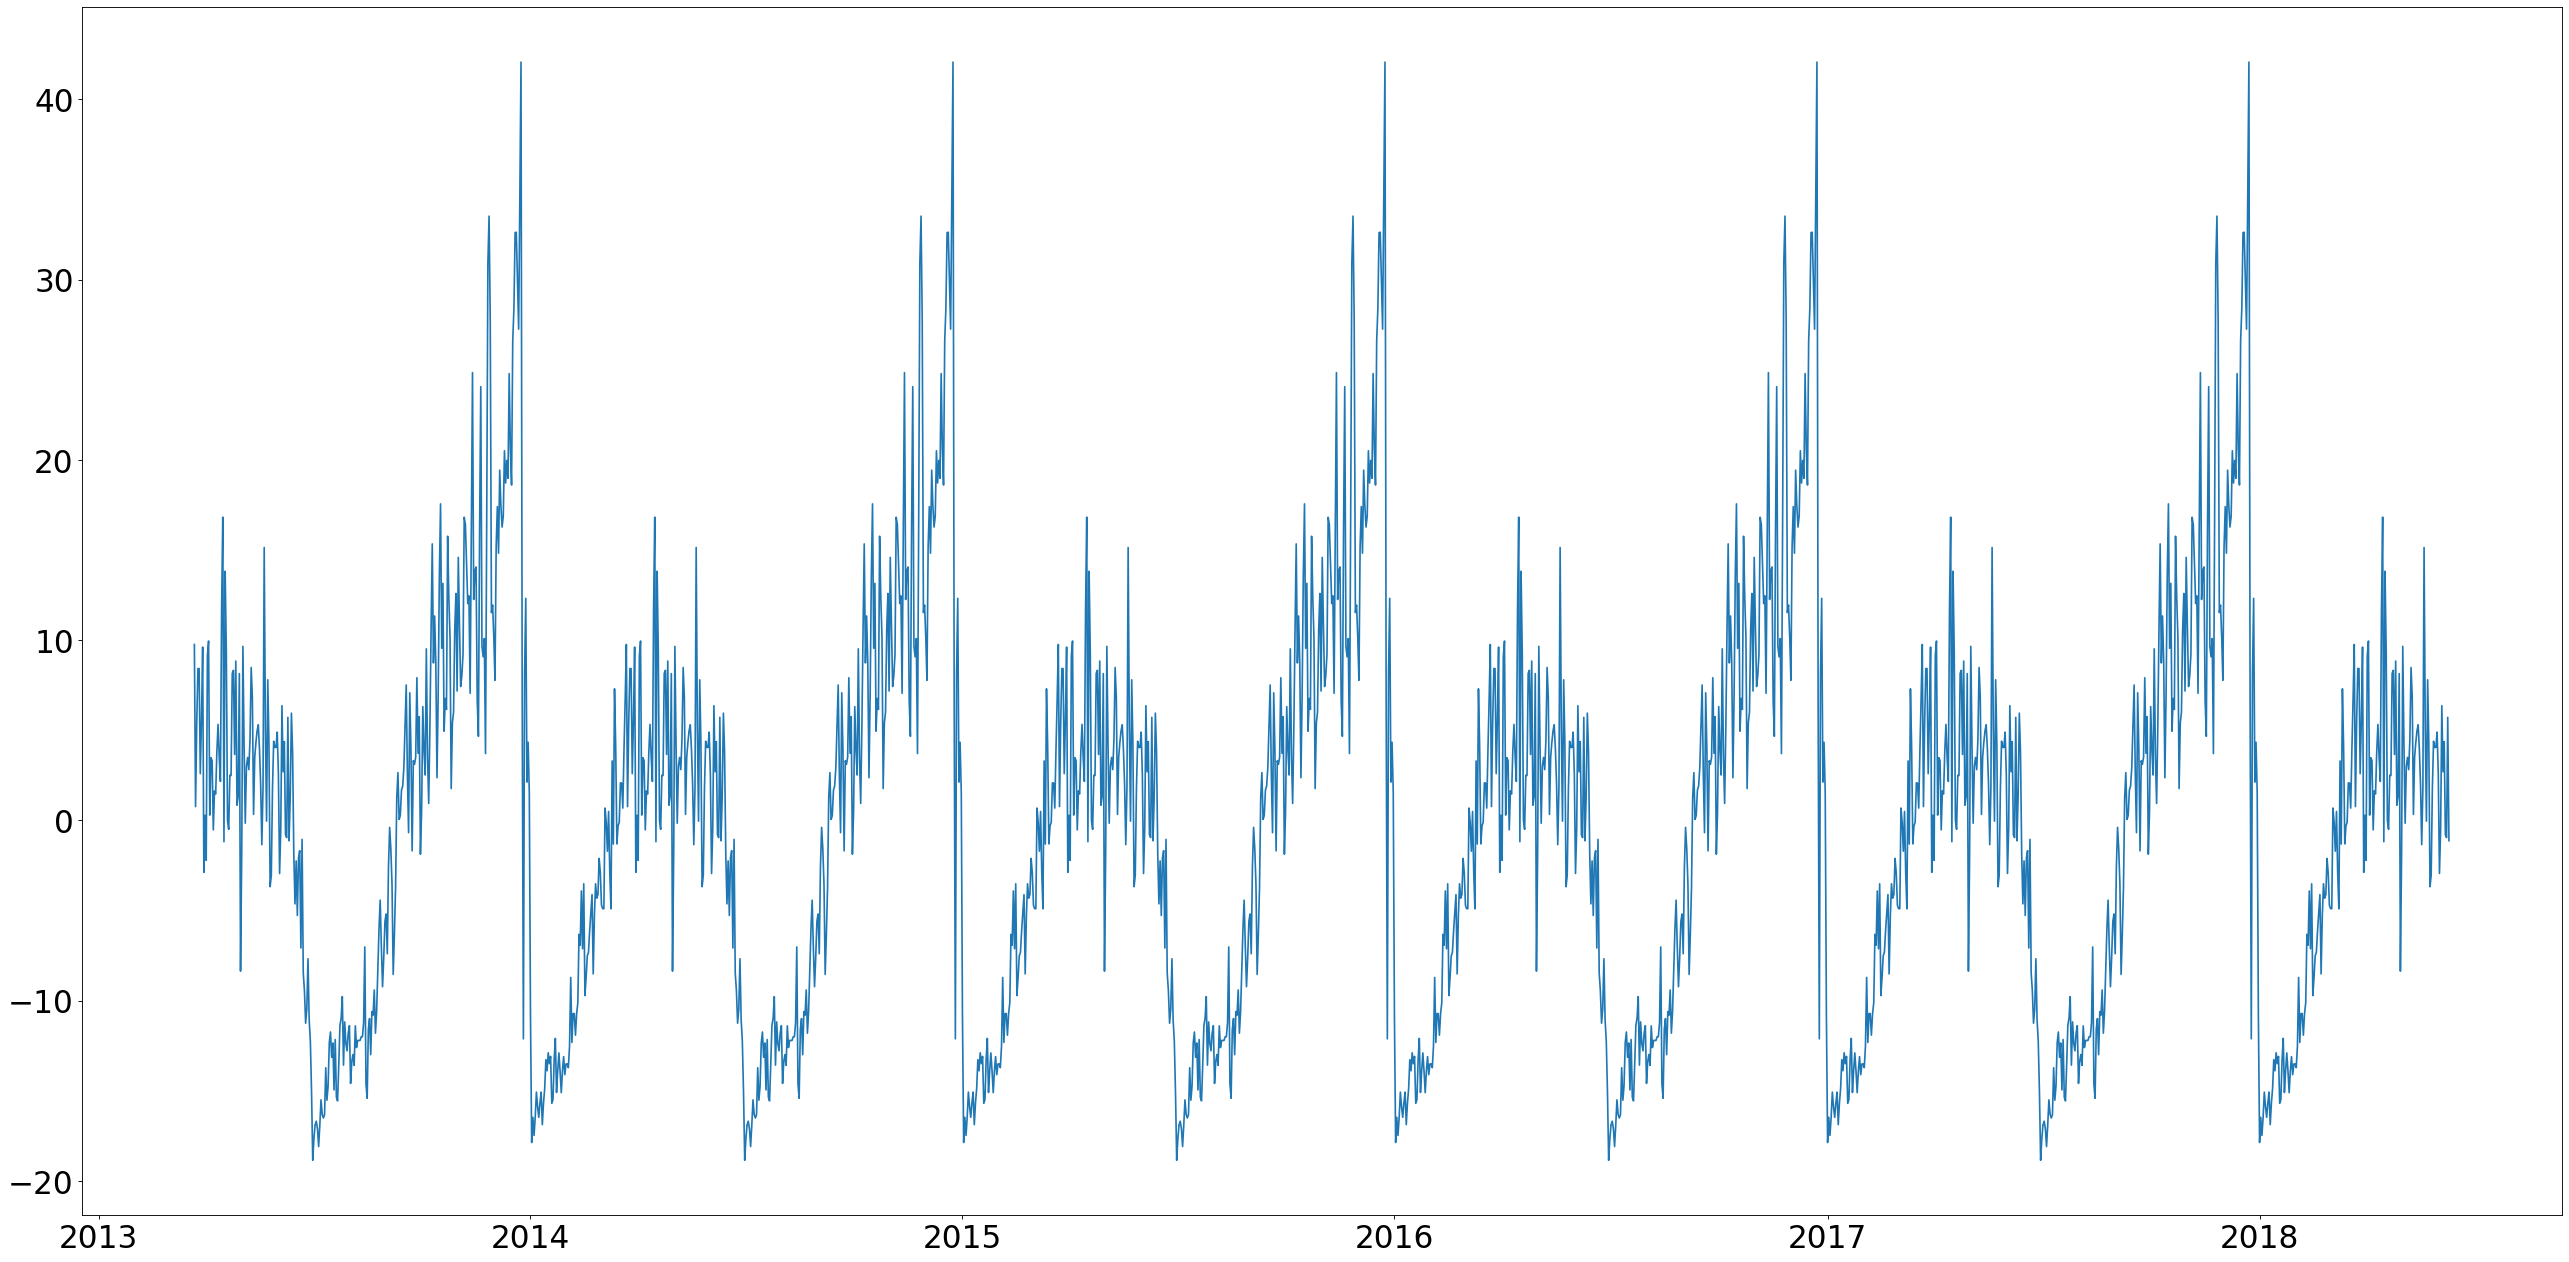

In [7]:
#%%
# Decompongo la serie
# con periodo di season giorni (year e half_year a seconda di cosa viene scelto all'inizio)

result = seasonal_decompose(train,  model = 'additive', period = season, extrapolate_trend='freq')

trend = result.trend
seasonality = result.seasonal
residuals = result.resid

# Calcolo il grado di forza della stagionalità

strength_seasonal = max(0, 1 - residuals.var()/(seasonality + residuals).var())
print('La forza della stagionalità di periodo {} è: {}'.format(season, strength_seasonal))

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(trend)
plt.figure(figsize=(40, 20), dpi=80)
plt.plot(residuals)
plt.figure(figsize=(40, 20), dpi=80)
plt.plot(seasonality)

Il grado di forza calcolato è inferiore a 0.64 quindi non applichiamo alcuna differenziazione stagionale.

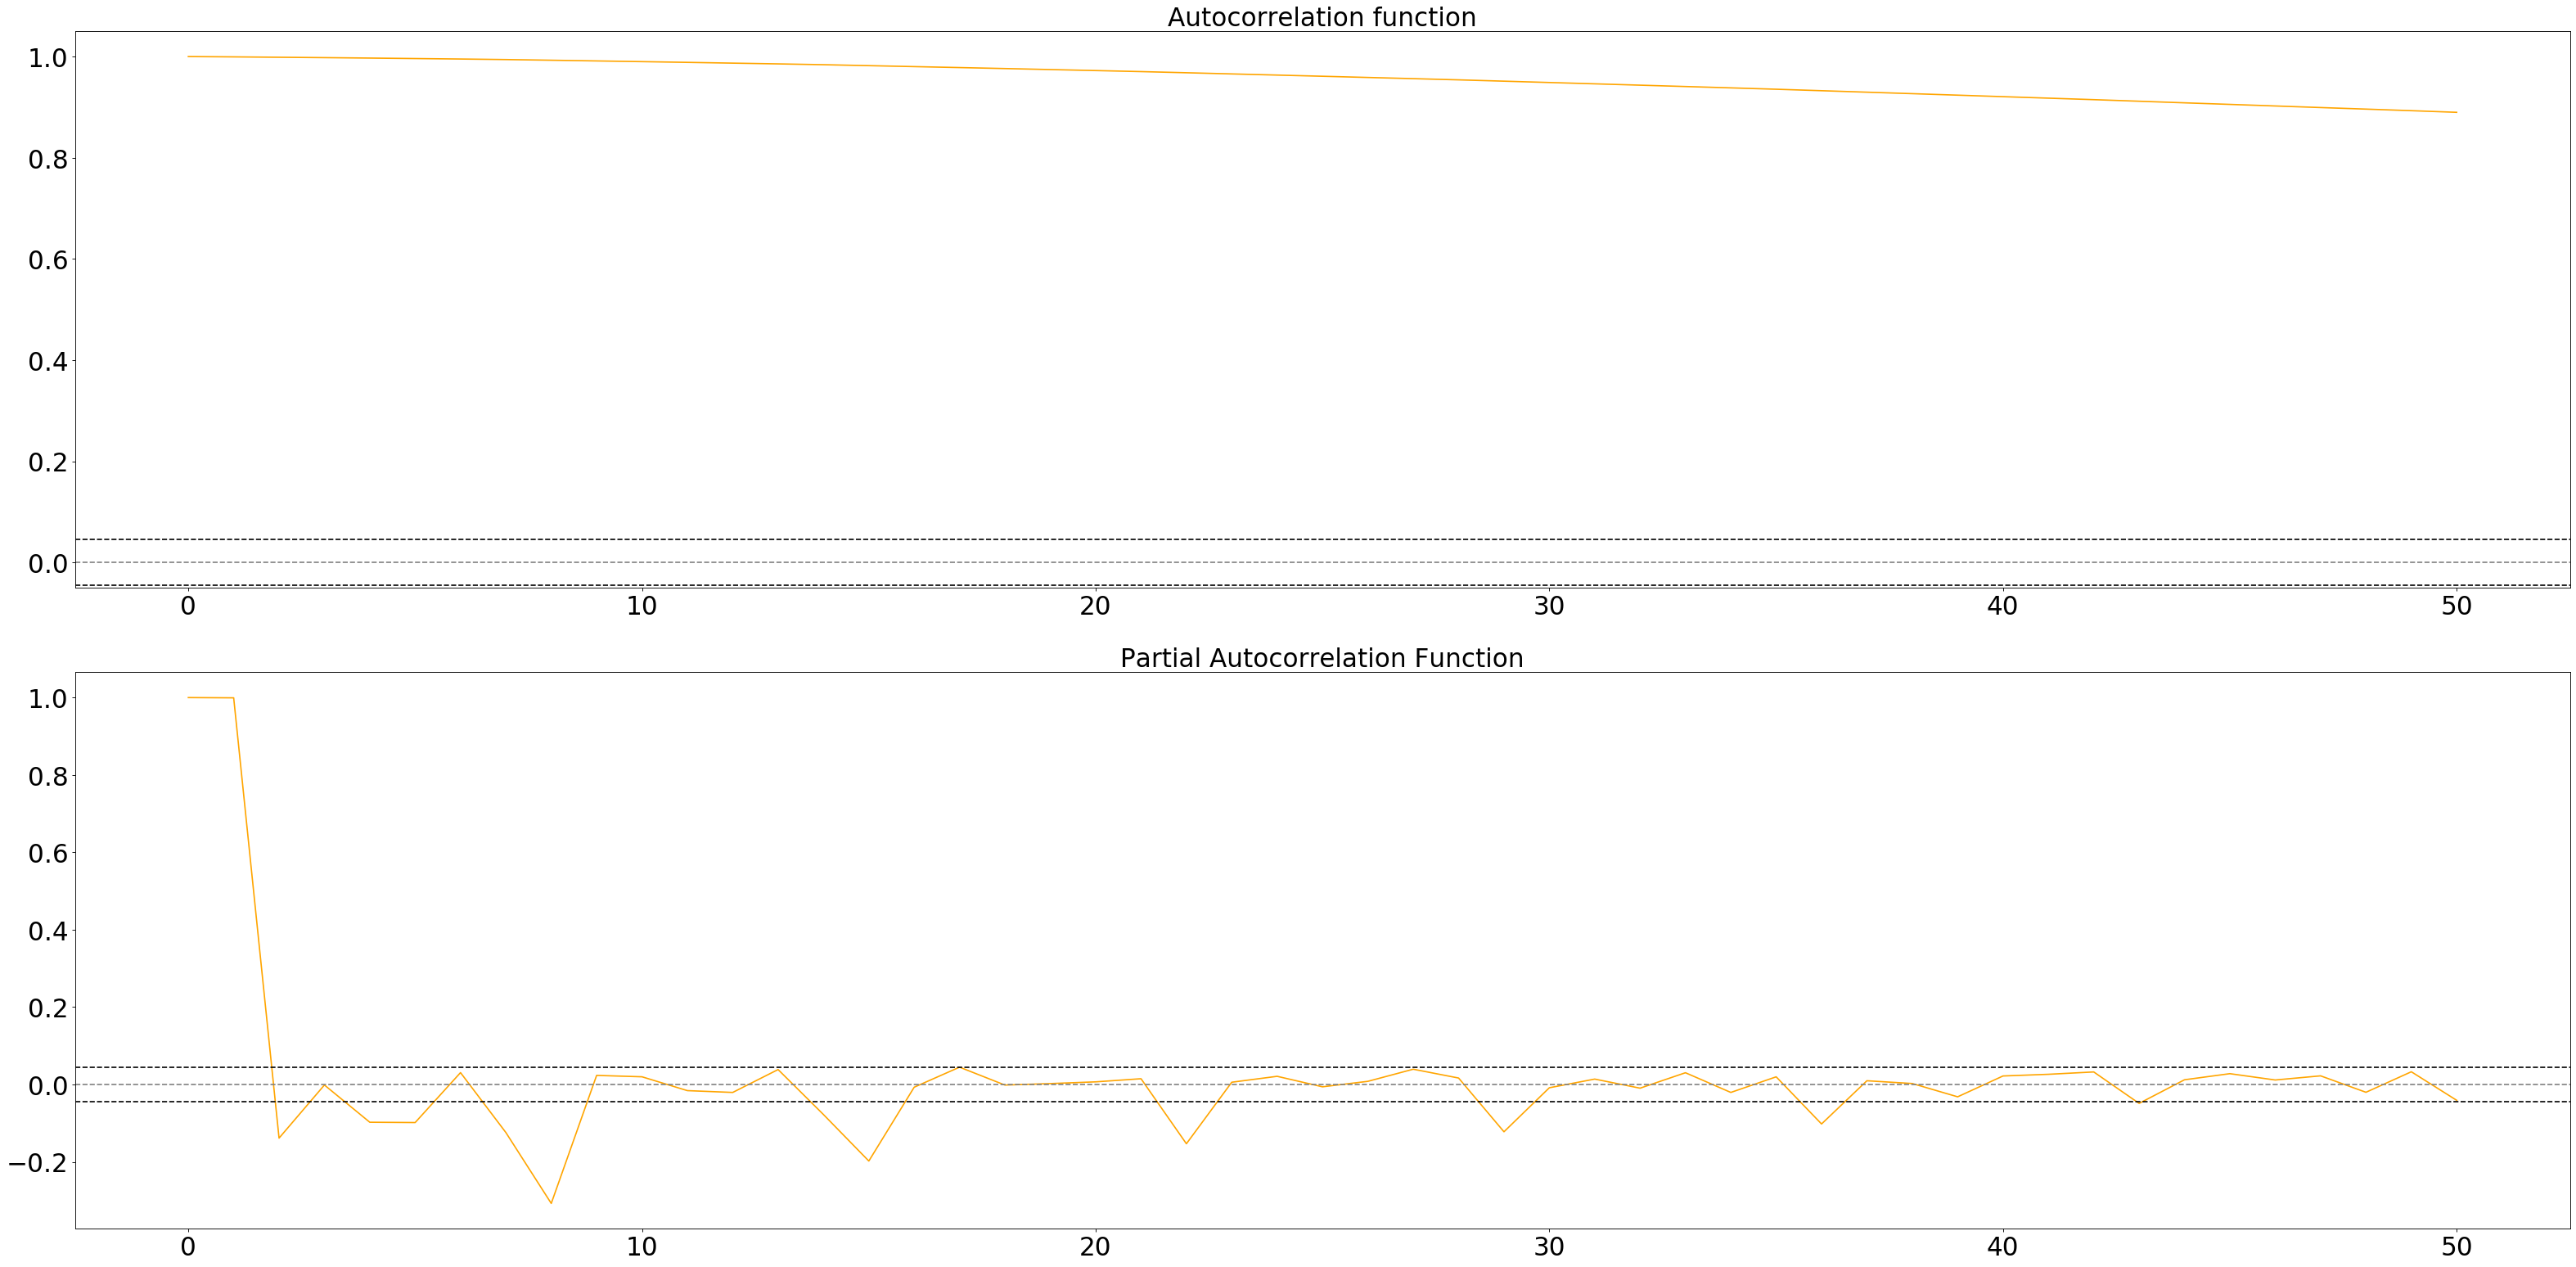

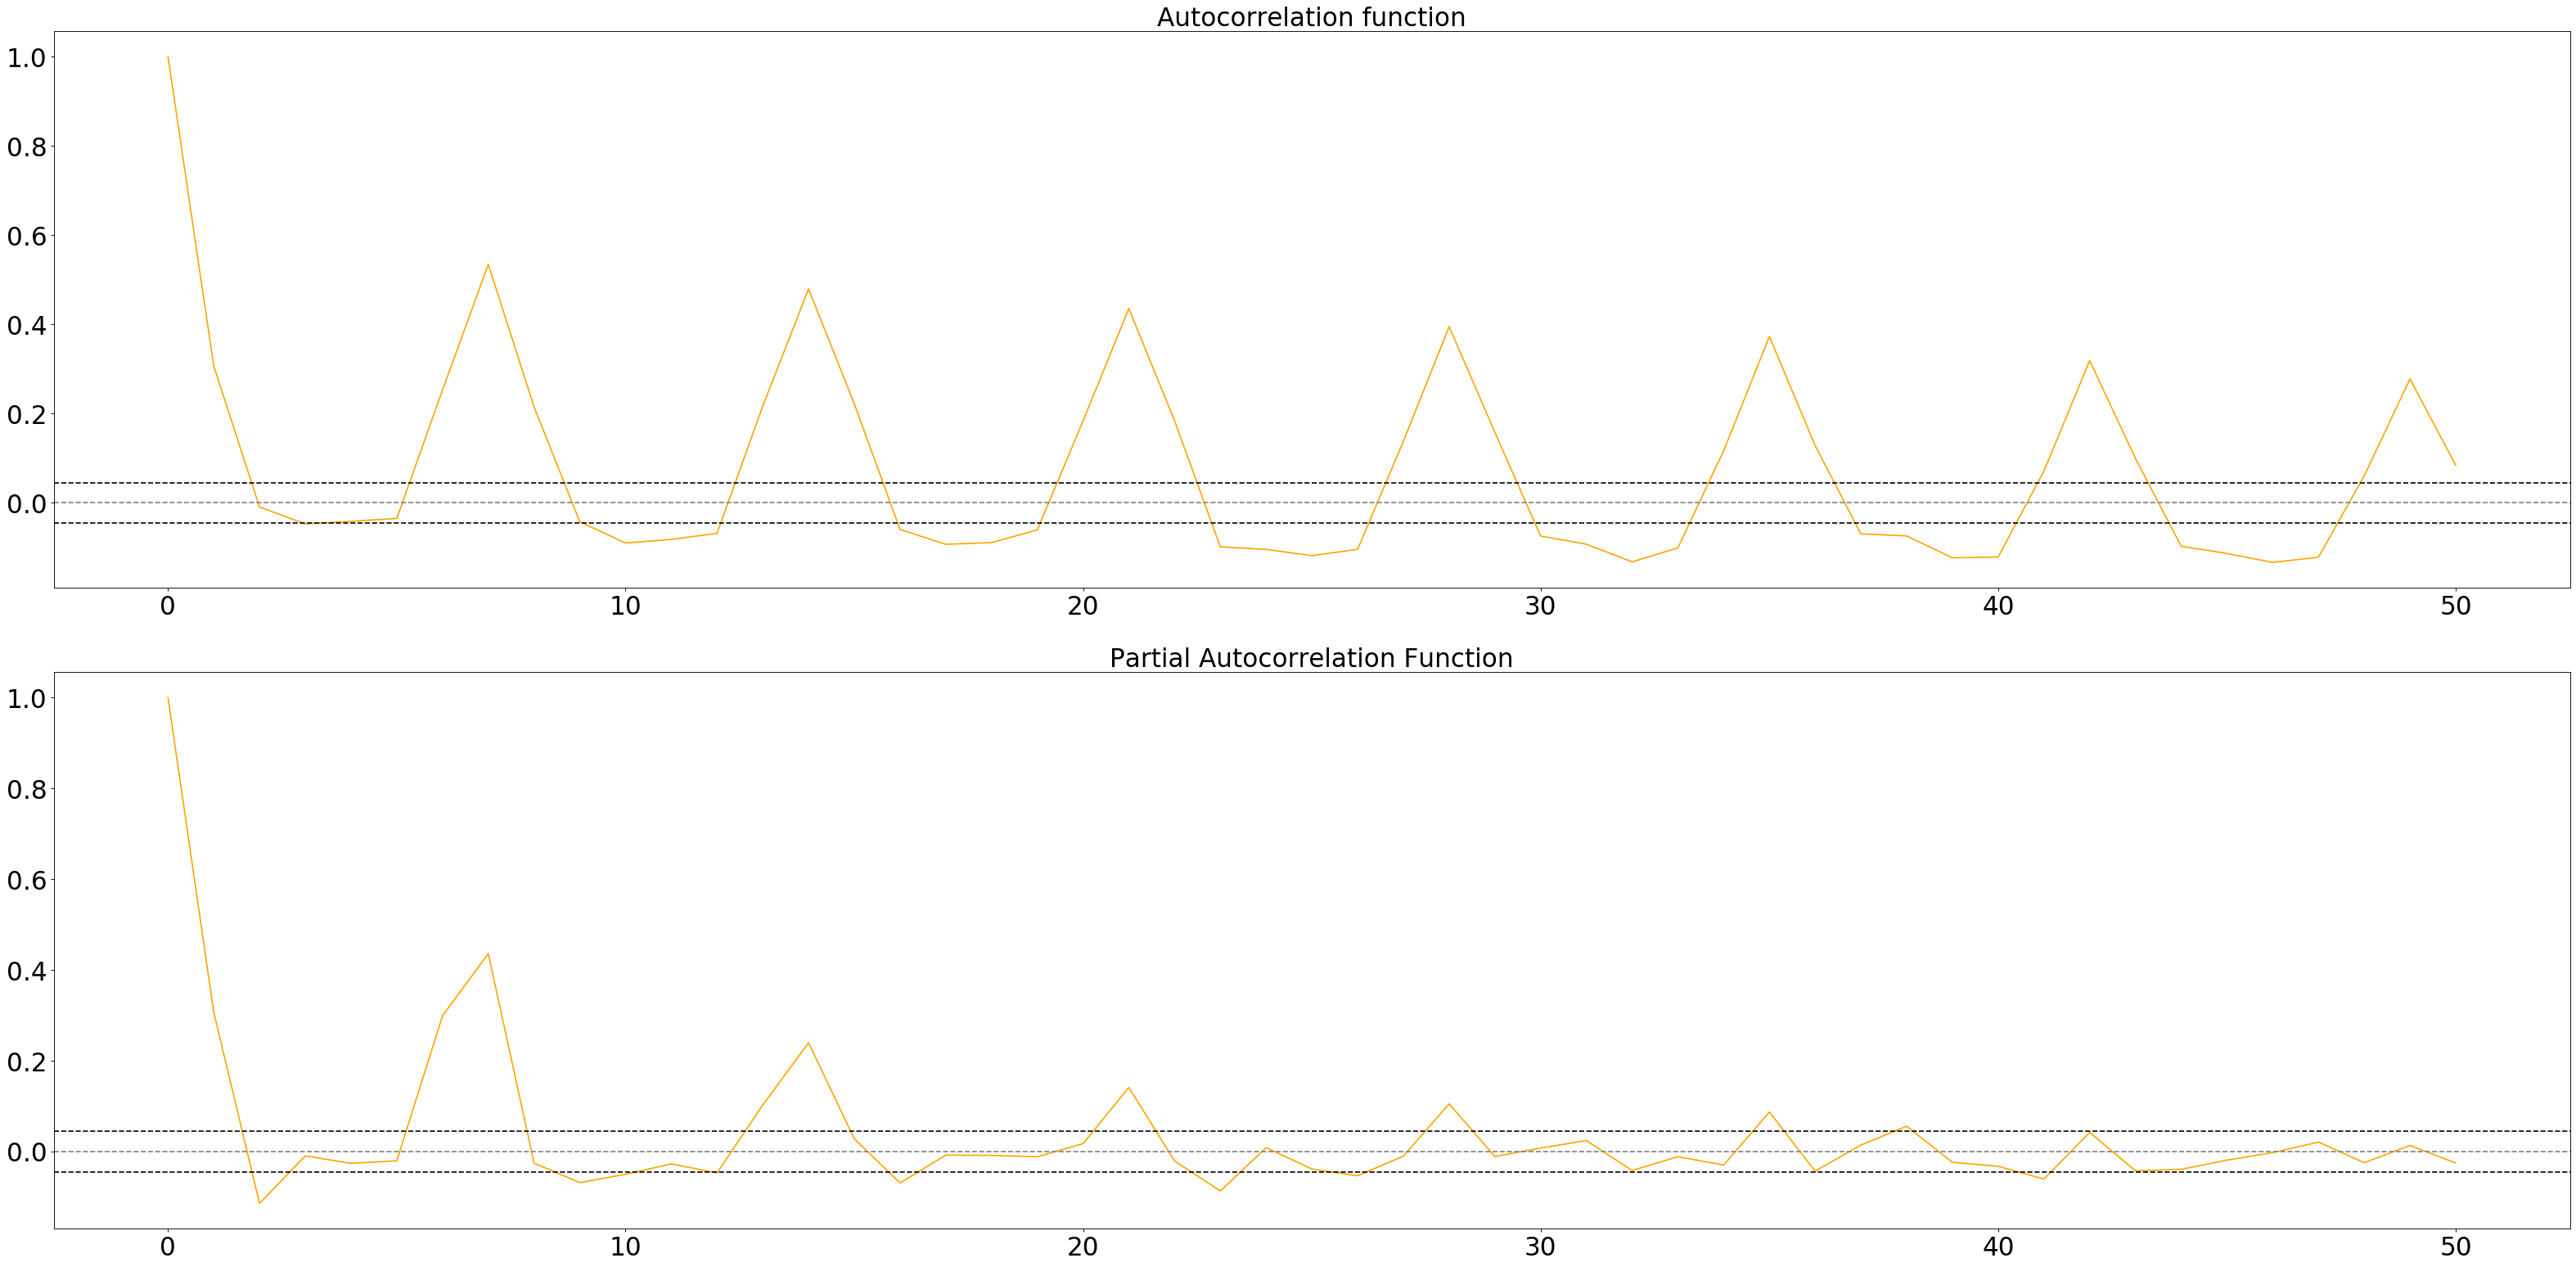

In [10]:
# Rimuovo i valori nulli

trend.dropna(inplace = True)
seasonality.dropna(inplace = True)
residuals.dropna(inplace = True)

# Verifico che non siano presenti ulteriori stagionalità nelle componenti trend e residuals

ac_pac_function(trend, lags = 50)
ac_pac_function(residuals, lags = 50)

In [11]:
# Genero tutte le combinazioni possibili di ordini (in totale sono 6 * 2 * 6 = 72)

p = q = range(0, 6)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Creo due variabili per confrontare i risultati delle applicazioni di ARIMA di ordini diversi e poter salvare il migliore

best = None
best_AIC = None

In [ ]:
# genero le previsioni della componente trend
# il processo per determinare gli ordini che forniscono il risultato migliore richiede molto tempo per il calcolo
# ordine 5,0,4 con stagione 183
# ordine 5,1,5 con stagione 365

for param in pdq:
    try:
        mod = ARIMA(trend, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if best is None:
            best = param
            best_AIC = results.aic
        elif results.aic < best_AIC:
            best_AIC = results.aic
            best = param
    except:
        continue

print('Gli ordini scelti per il trend sono {} con un AIC di {}'.format(best, best_AIC))

In [12]:
best = [5, 1, 5]

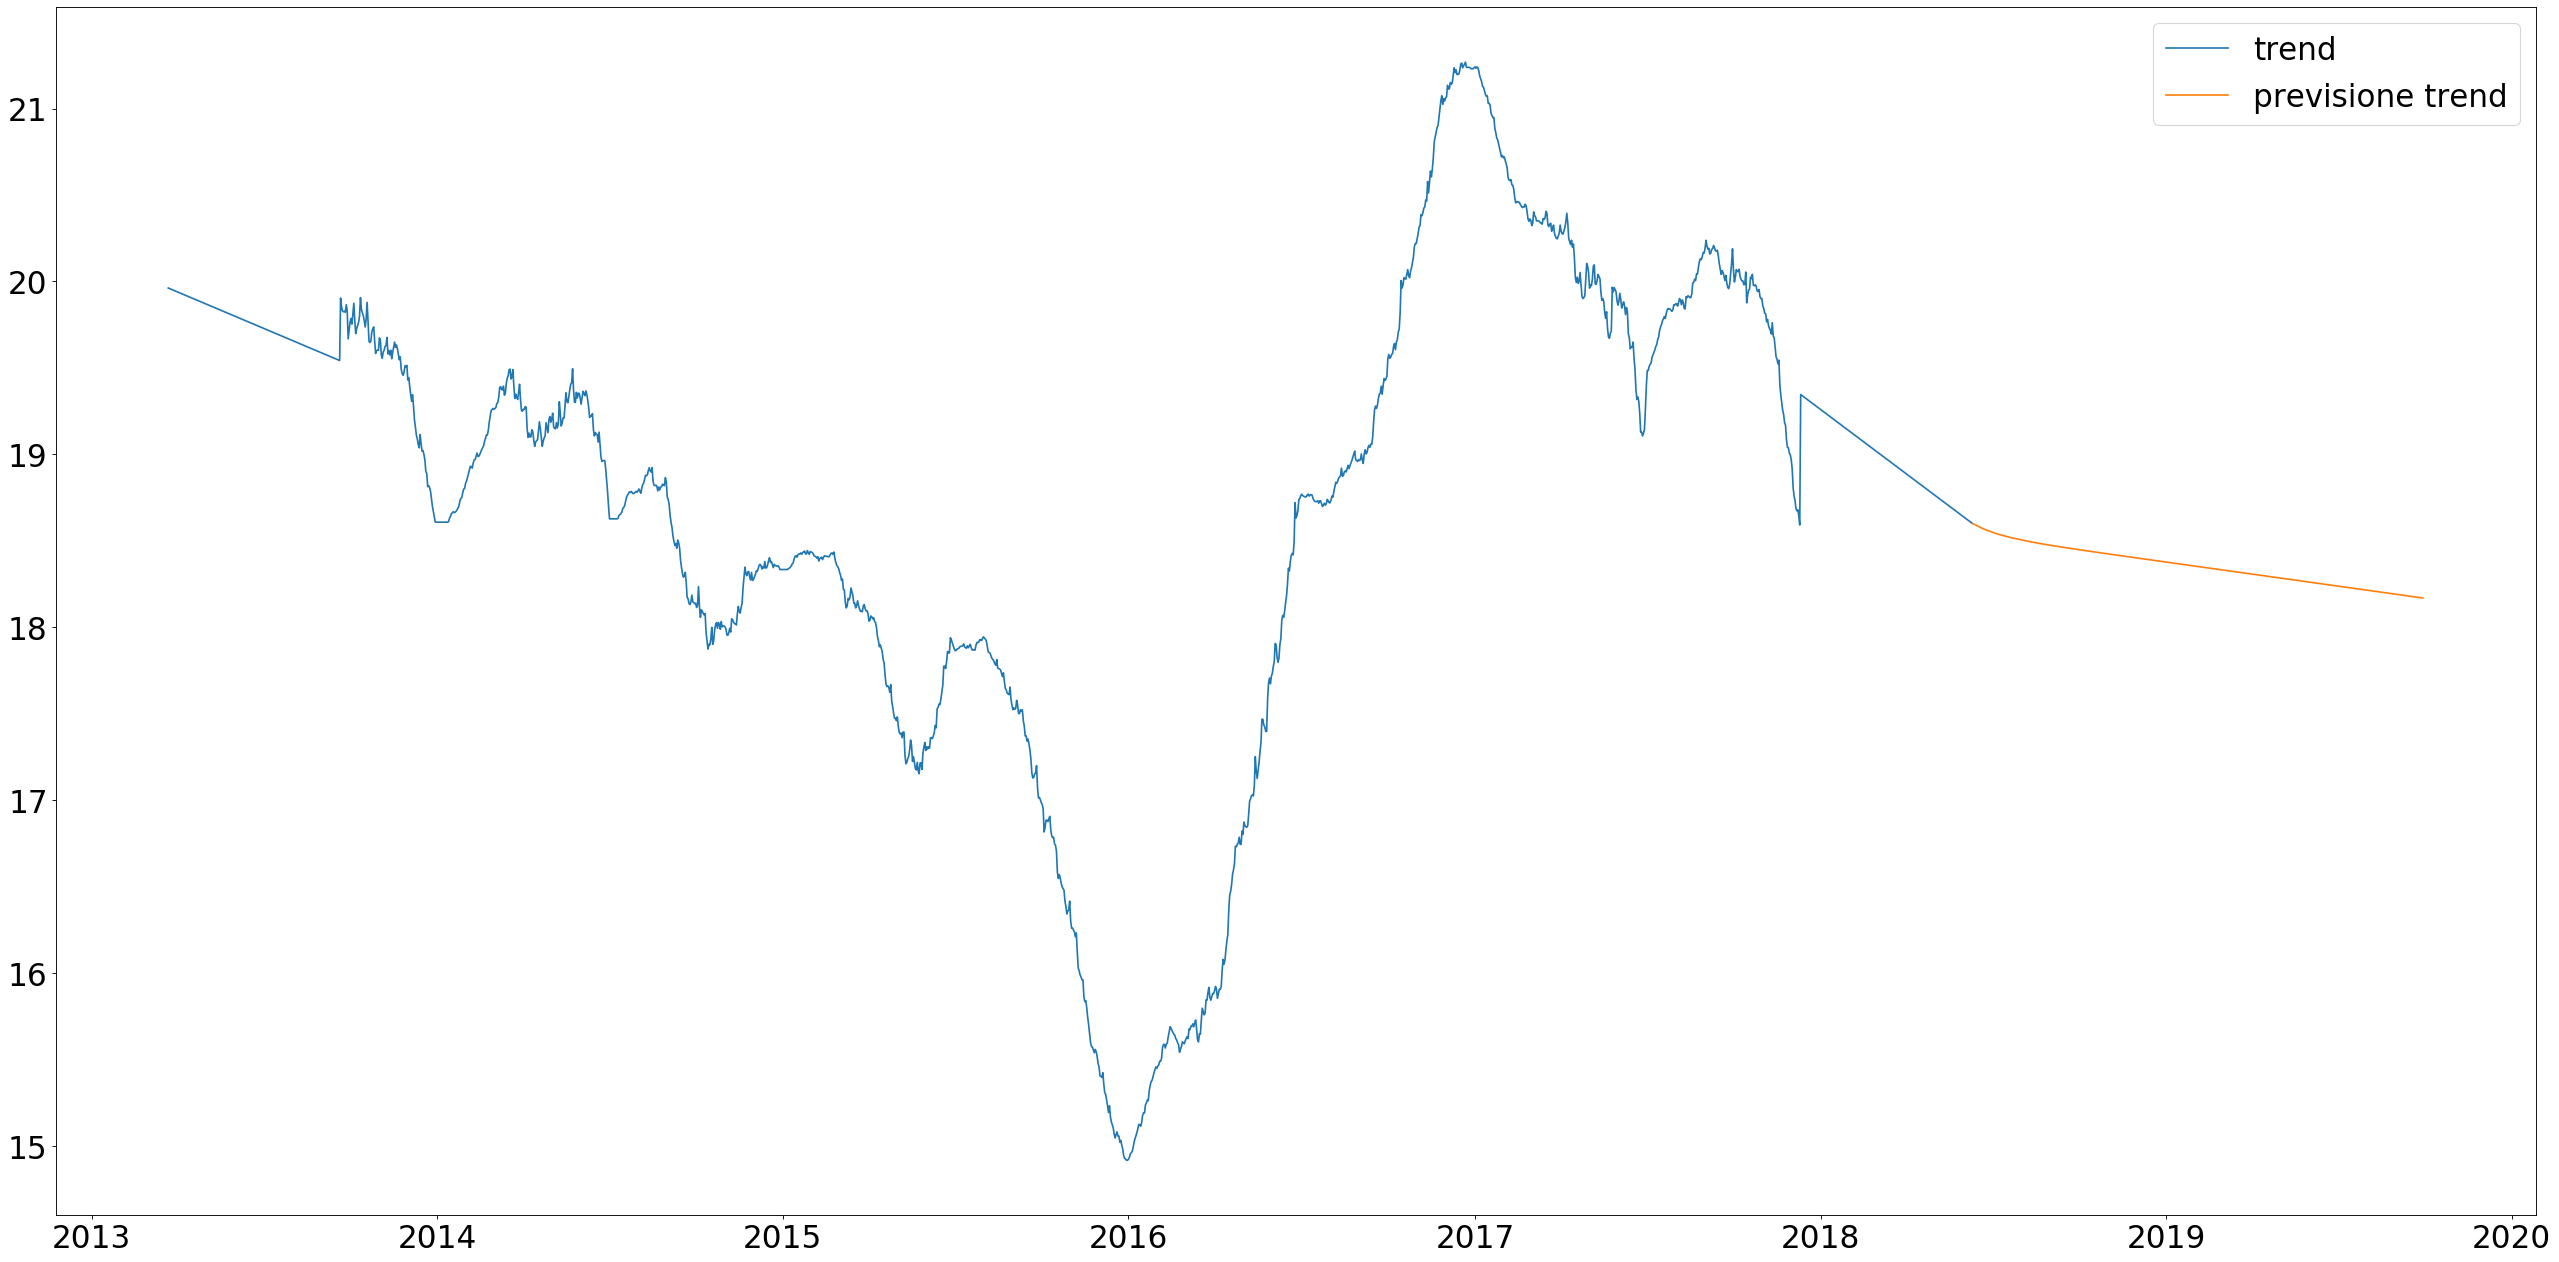

In [13]:
# Applicazione ARIMA

trend_model = ARIMA(trend, order=best)
trend_fitted = trend_model.fit()

"""fitted.summary()"""
# Se è stata applicata differenziazione (d = 1) per ritornare nella forma originale sarà necessario calcolare le somme cumulative
# aggiungendo il valore iniziale della serie da cui si è generato il modello, altrimenti rimarrà scostata di tale valore rispetto
# alle osservazioni!

trend_predictions, _, confidence_int = trend_fitted.forecast(steps = len(valid))
ts_trend_predictions = pd.Series(trend_predictions, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D')) 
trend_modfit = pd.Series(trend_fitted.fittedvalues, index=pd.date_range(start=ts.index[0], end=ts.index[int(len(ts) * 0.8)], freq='D'))
if best[1] == 1:
    trend_modfit[0] = trend[0]
    trend_modfit = trend_modfit.cumsum()


plt.figure(figsize=(40, 20), dpi=80)
plt.plot(trend, label='trend')
plt.plot(ts_trend_predictions, label='previsione trend')
plt.legend(loc = 'best')

In [ ]:
# genero le previsioni della componente residuals
# il processo per determinare gli ordini che forniscono il risultato migliore richiede molto tempo per il calcolo
# ordine 5,0,5 con stagione 183
# ordine 5,0,5 con stagione 365

best = None
best_AIC = None
for param in pdq:
    try:
        mod = ARIMA(residuals, order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if best is None:
            best = param
            best_AIC = results.aic
        elif results.aic < best_AIC:
            best_AIC = results.aic
            best = param
    except:
        continue

print('Gli ordini scelti per i residui sono {} con un AIC di {}'.format(best, best_AIC))

In [16]:
# Per evitare il calcolo
best = [5, 0, 5]

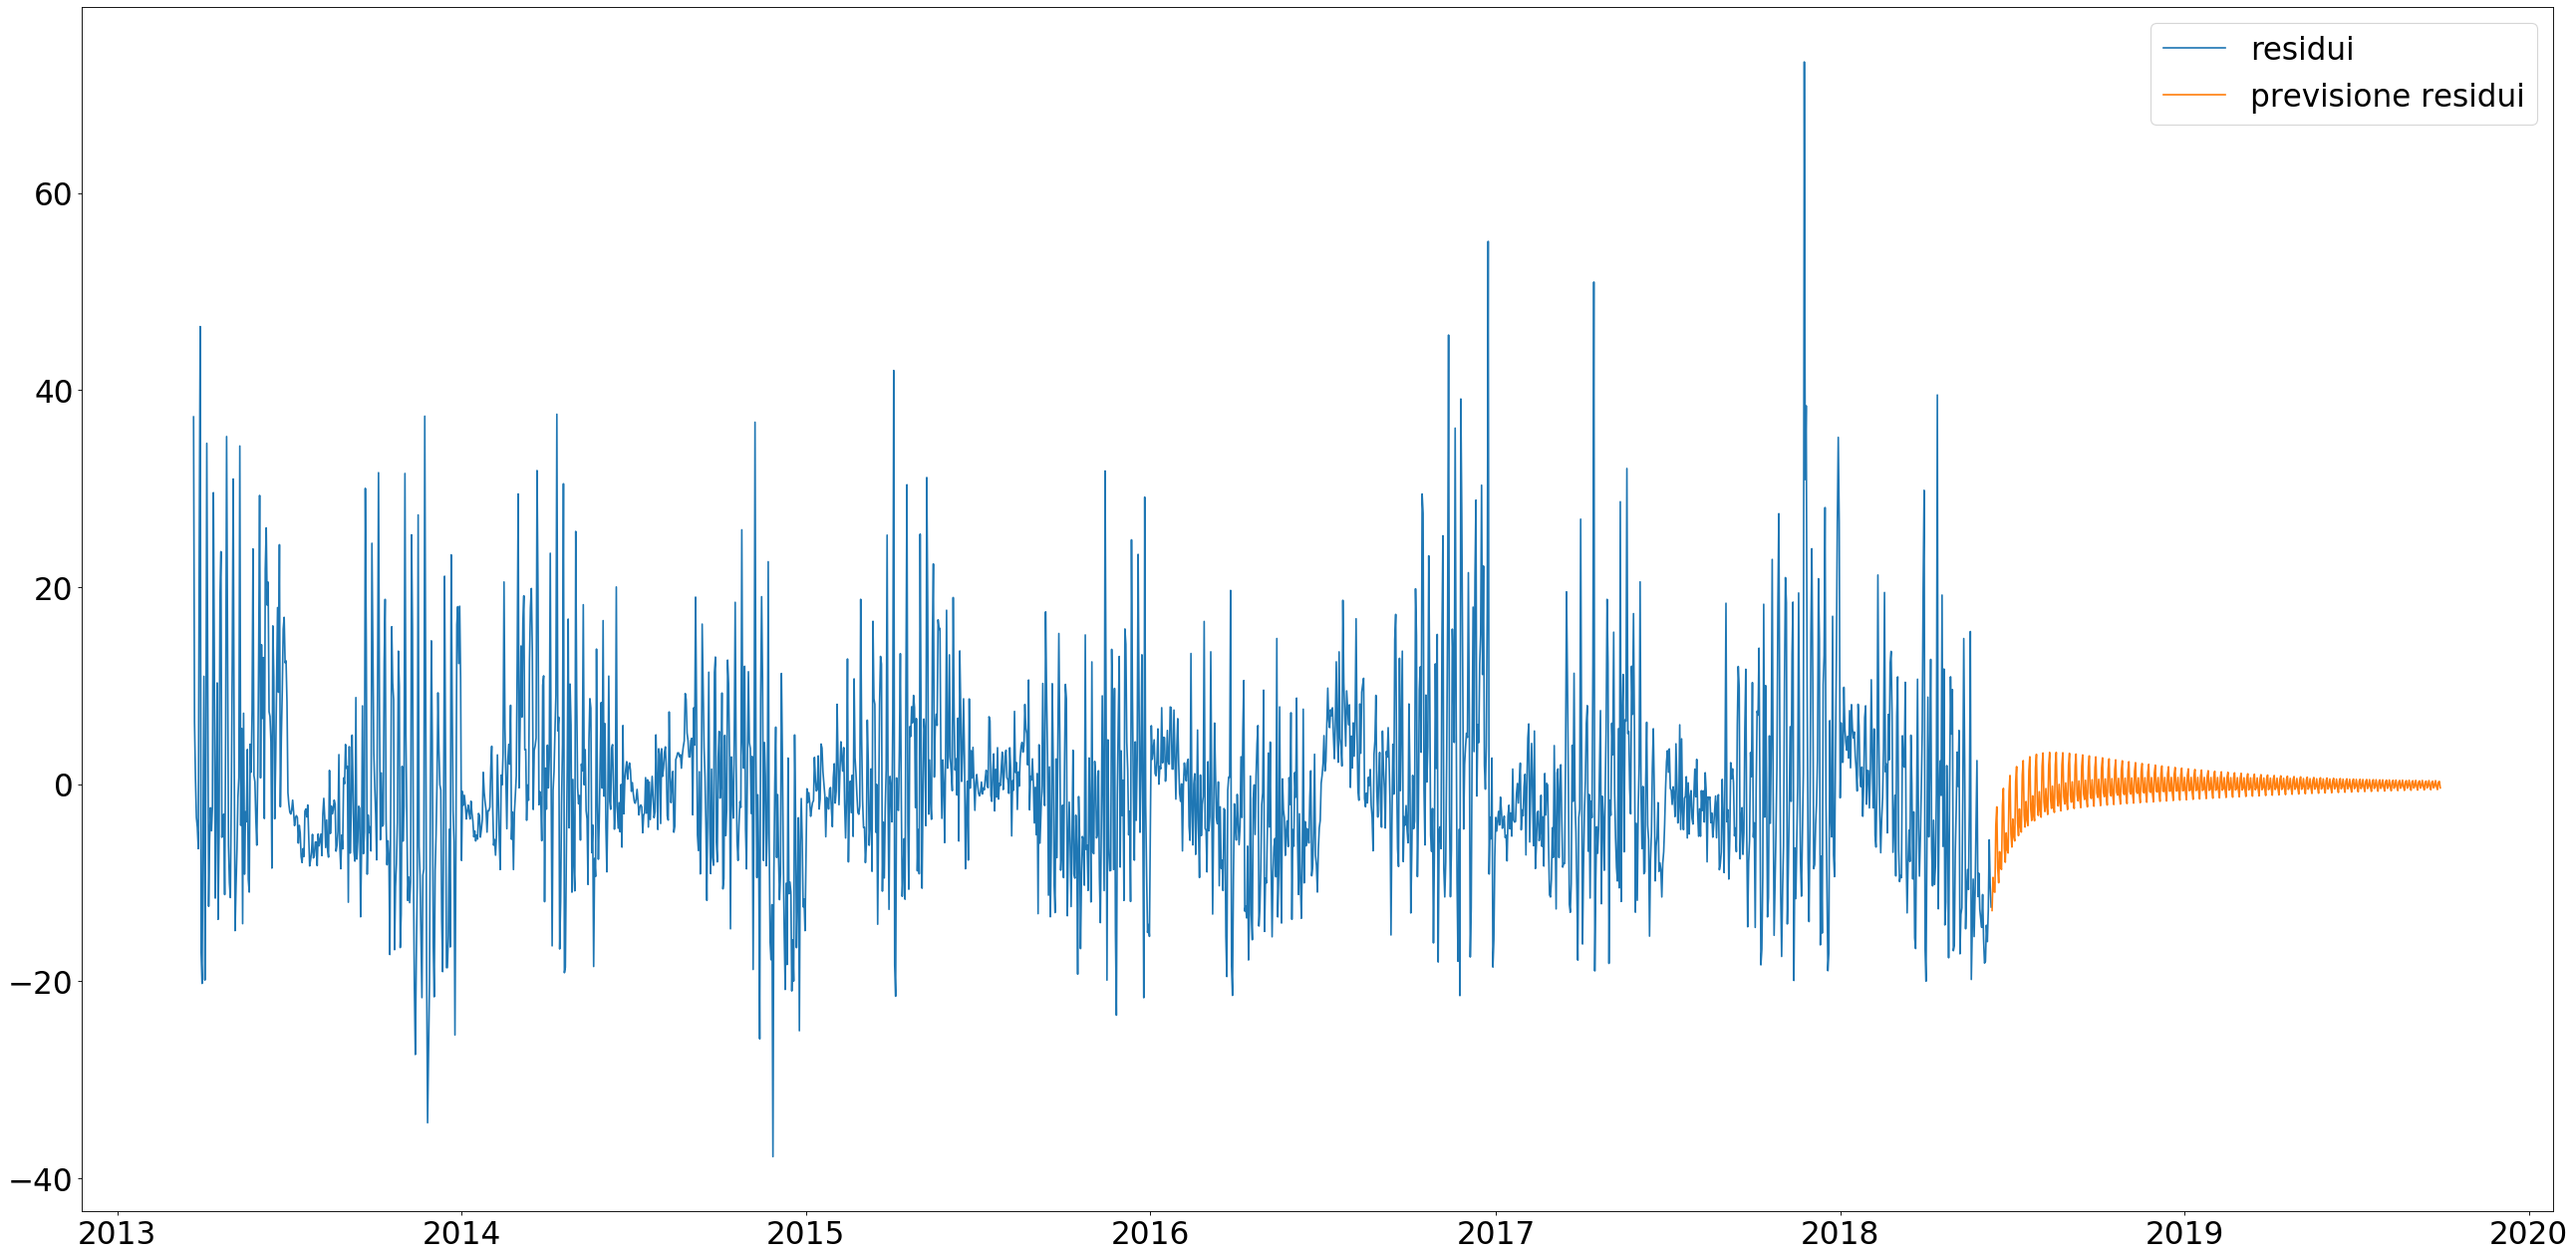

In [17]:
# Applico ARIMA

residuals_model = ARIMA(residuals, order=best)
residuals_fitted = residuals_model.fit()
"""fitted.summary()"""

# Ottengo le previsioni

residuals_predictions, _, confidence_int = residuals_fitted.forecast(steps = len(valid))
ts_residuals_predictions = pd.Series(residuals_predictions, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D')) 

# Se è stata applicata differenziazione (d = 1) per ritornare nella forma originale sarà necessario calcolare le somme cumulative
# aggiungendo il valore iniziale della serie da cui si è generato il modello, altrimenti rimarrà scostata di tale valore rispetto
# alle osservazioni!

residuals_modfit = pd.Series(residuals_fitted.fittedvalues, index=pd.date_range(start=ts.index[0], end=ts.index[int(len(ts) * 0.8)], freq='D'))
if best[1] == 1:
    residuals_modfit[0] = residuals[0]
    residuals_modfit = residuals_modfit.cumsum()


plt.figure(figsize=(40, 20), dpi=80)
plt.plot(residuals, label='residui')
plt.plot(ts_residuals_predictions, label='previsione residui')
plt.legend(loc = 'best')

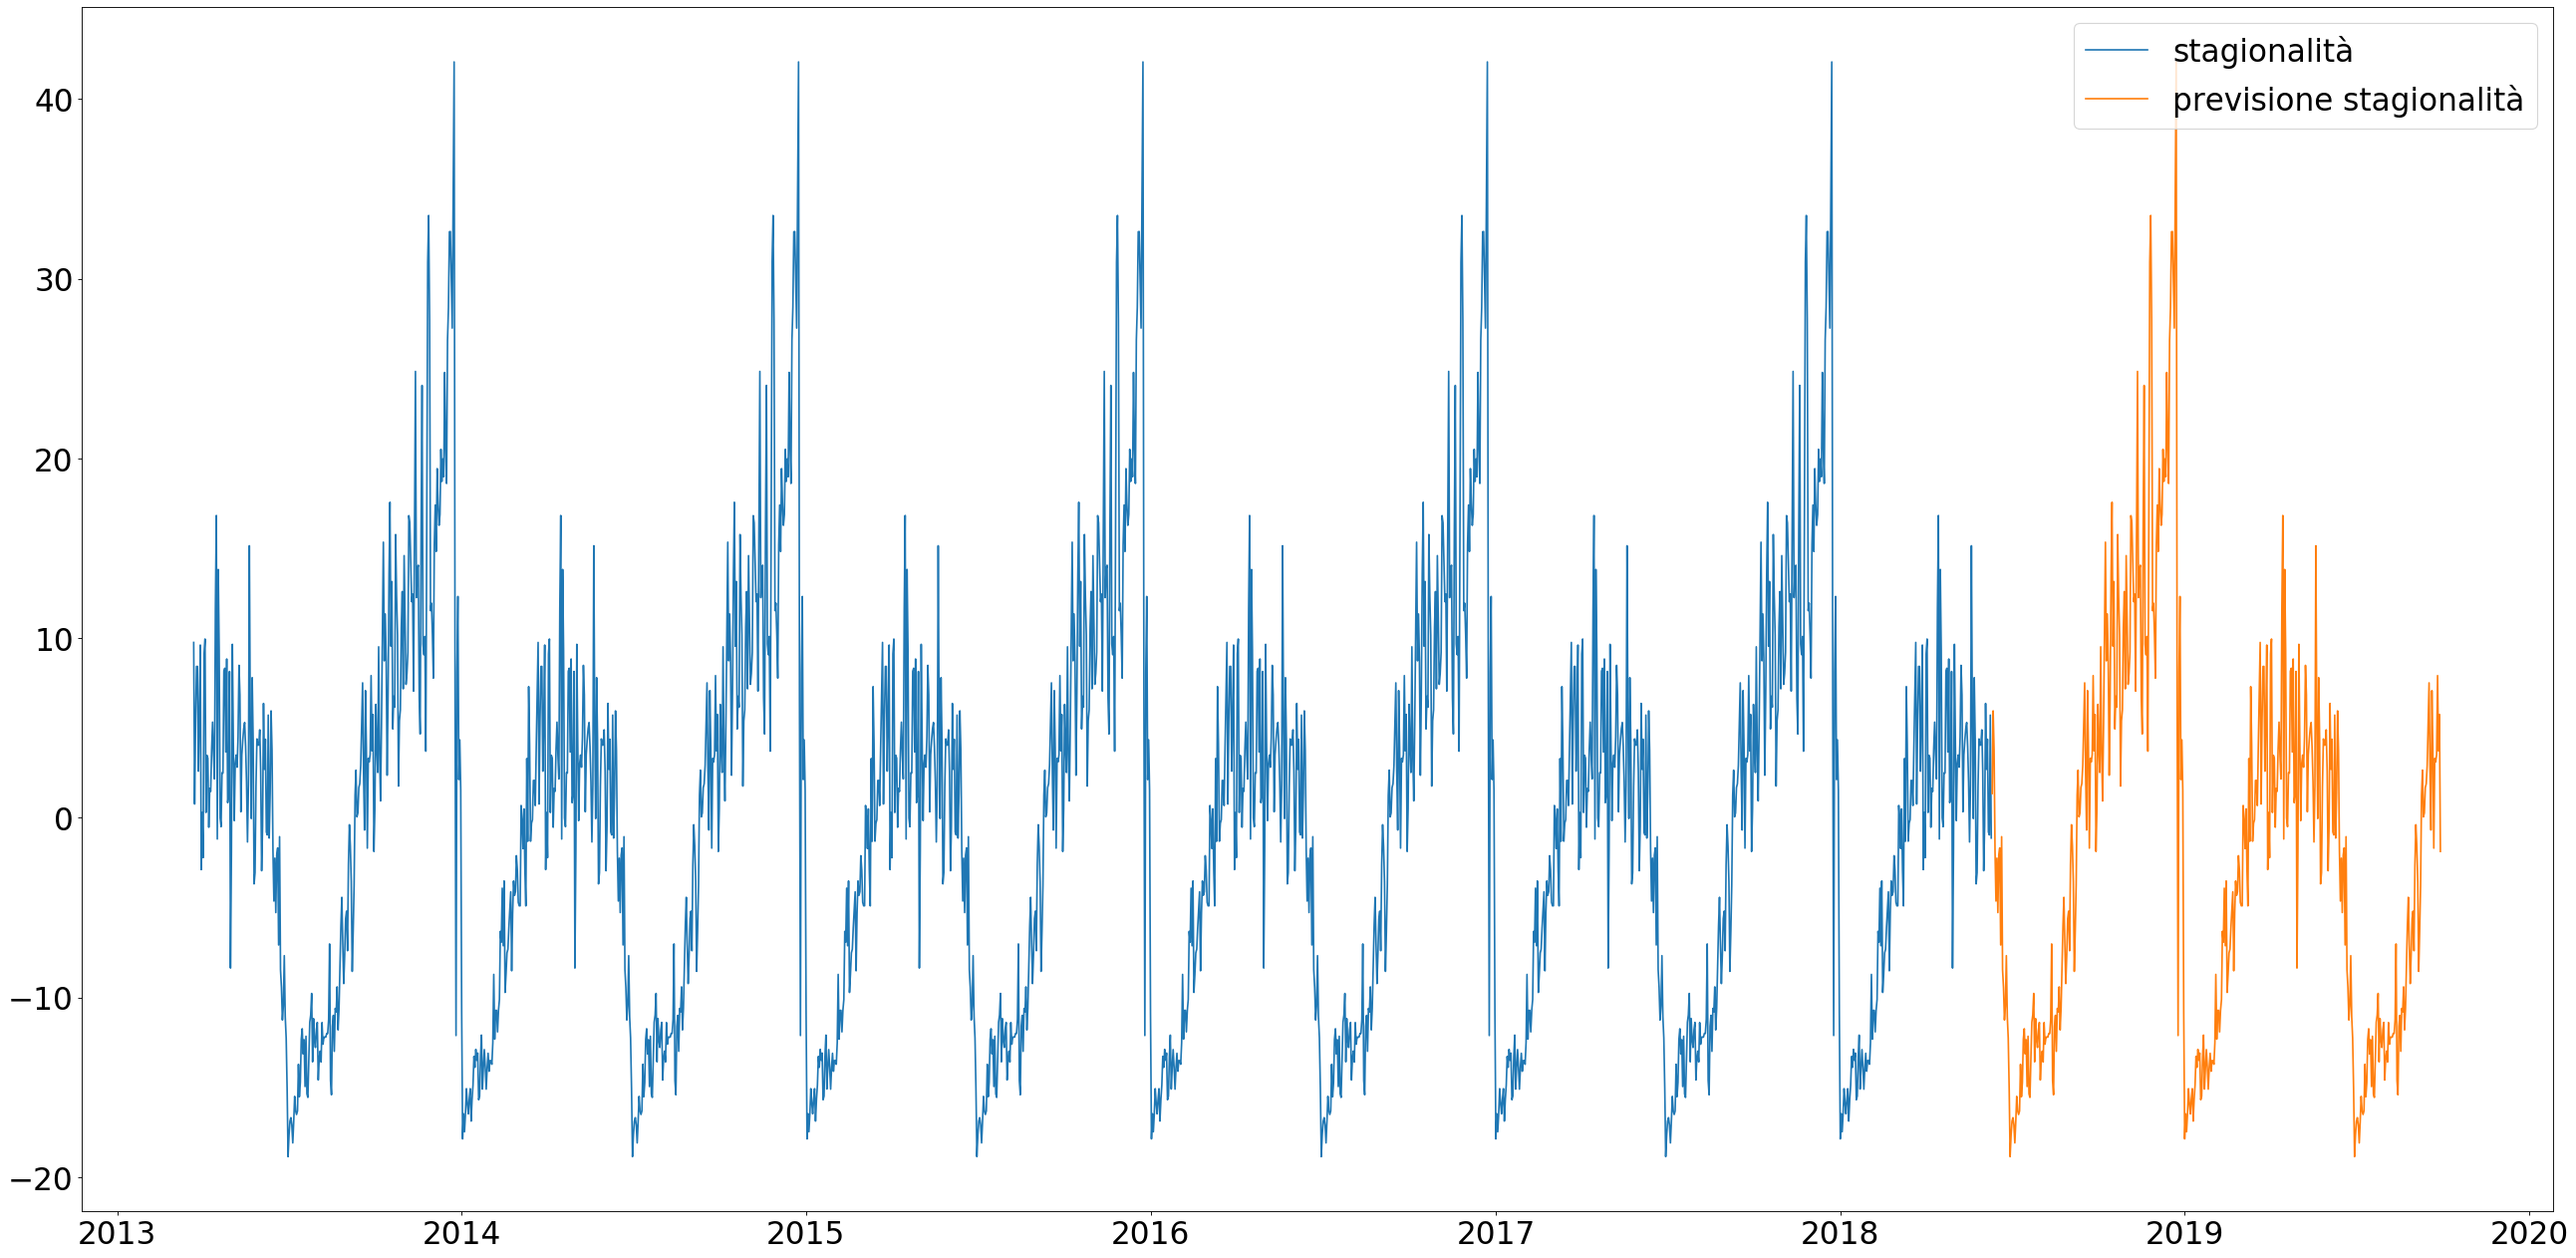

In [18]:
# genero le previsioni della componente stagionale usando il metodo seasonal naive (ricopiando le n osservazioni precedenti
# tenendo conto della stagionalità)

predictions_seasonality = []
for i in range (0, len(valid)):
    if i < season:
        predictions_seasonality.append(seasonality[len(seasonality)-season+i])
    else:
        predictions_seasonality.append(predictions_seasonality[i%season])

# produco la serie temporale dalla lista di valori usando come indice le date del validation set        

ts_predictions_seasonality = pd.Series(predictions_seasonality, index=pd.date_range(start=ts.index[int(len(ts)*0.8)+1], end = ts.index[int(len(ts))-1], freq='D'))

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(seasonality, label='stagionalità')
plt.plot(ts_predictions_seasonality, label='previsione stagionalità')
plt.legend(loc='best');

2018-06-11     7.122293
2018-06-12    15.083669
2018-06-13    11.440284
2018-06-14     5.792416
2018-06-15     9.826753
Freq: D, dtype: float64
Calcoliamo  MAE=8.2124
Calcoliamo MSE: 147.3166


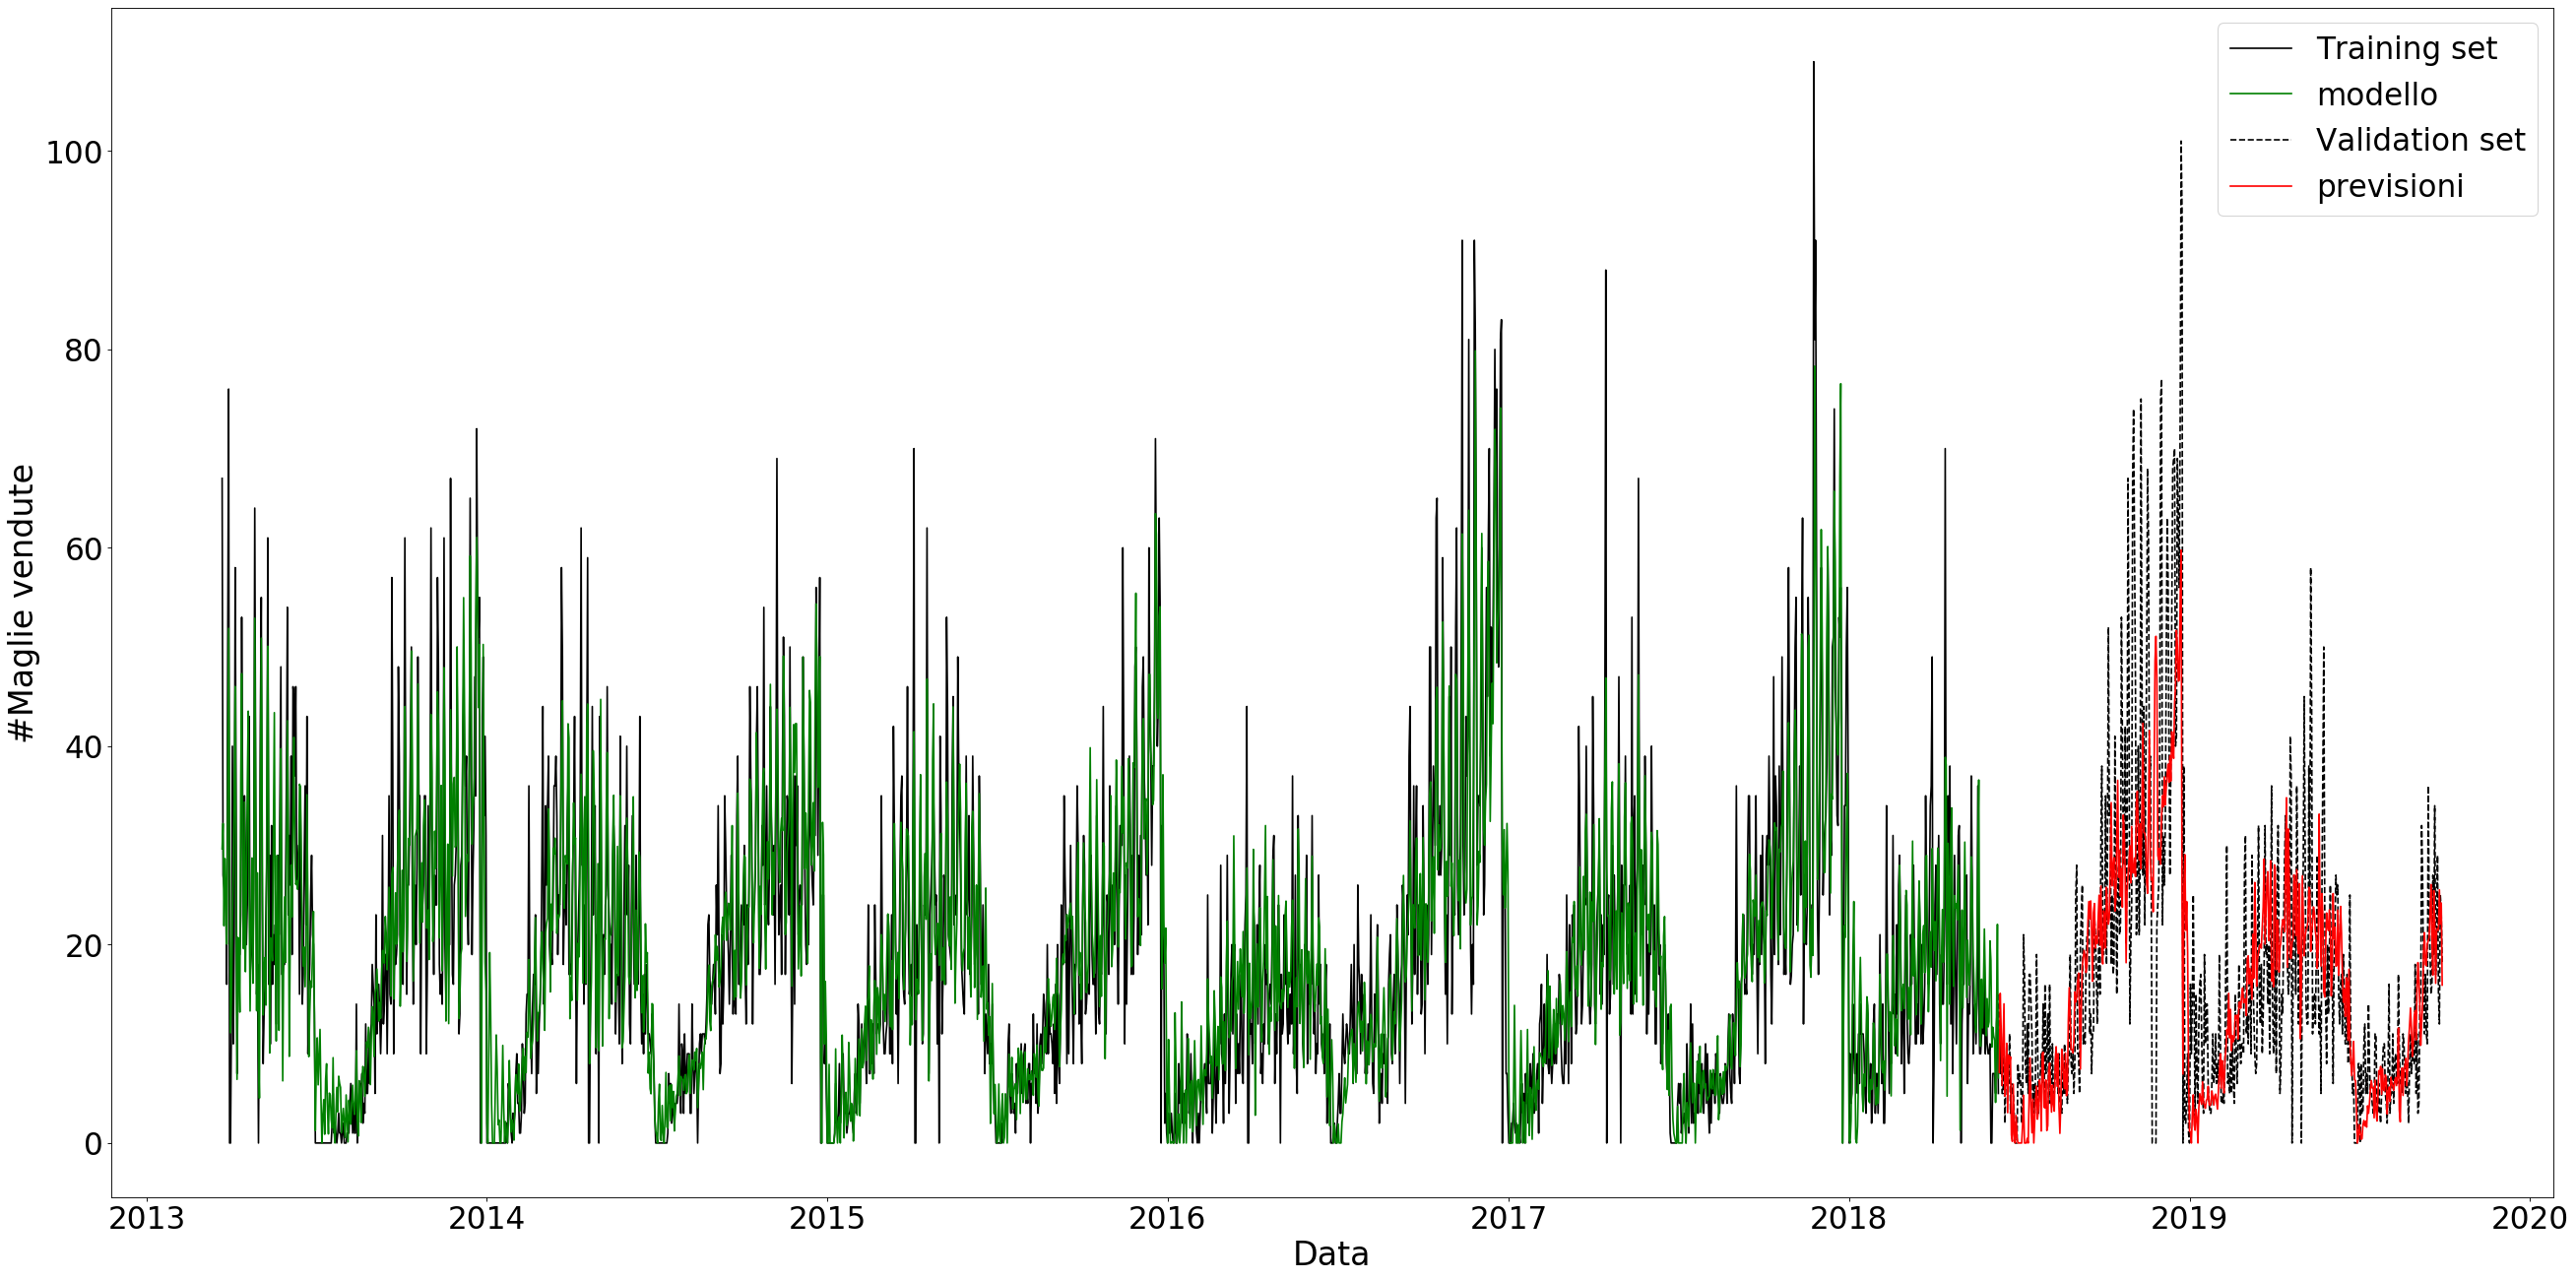

In [21]:
# Torno alla forma iniziale sommando le componenti del modello 

model = trend_modfit + residuals_modfit + seasonality

# Calcolo le previsioni (per il periodo di validazione, con cui fare il confronto
# per determinarne la bontà)

predictions = ts_residuals_predictions + ts_predictions_seasonality + ts_trend_predictions

# Arrotondo le previsioni a zero per valori negativi (in quanto non hanno senso vendite negative). In questo
# modo otterrò metriche di errore migliori!

"""
for i in range (0, len(model)):
    if model[i] < 0:
        model[i] = 0
"""

for i in range (0, len(predictions)):
    if predictions[i] < 0:
        predictions[i] = 0

# Plot del modello ARIMA con la serie per il training in scala originale

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(train, label = "Training set", color = 'black')
plt.plot(model, color='green', label='modello')
plt.plot(valid, color='black', linestyle='--', label = 'Validation set')
plt.legend(loc='best');

ci = 1.96 * np.std(predictions)/np.mean(predictions)
plt.plot(predictions, color="red", label='previsioni')
plt.xlabel('Data')
plt.ylabel('#Maglie vendute')
plt.legend(loc='best')
print(predictions.head())

errore = predictions - valid
errore.dropna(inplace=True)

# Metriche di errore per verificare la bontà dei risultati

print("Calcoliamo  MAE=%.4f"%(sum(abs(errore))/len(errore)))
print('Calcoliamo MSE: %.4f'%(sum((predictions-valid)**2)/len(valid)))

## Exponential Smoothing (ETS)

Il metodo exponential smoothing utilizza medie pesate delle osservazioni passate con pesi che decadono esponenzialmente con l'avanzare nel tempo per compiere le previsioni: più recenti sono le osservazioni più viene data loro importanza (peso maggiore).

### Simple Exponential Smoothing

Il modello simple exponential smoothing richiede pochissima computazione ed è utilizzato quando l'insieme dei dati non è approssimativamente orizzontale (non presenta trend e stagionalità). I valori generati dall'applicazione del modello sono dati da:

\begin{equation}
\overline y_{i} = \alpha y_i + (1-\alpha )\overline y_{i-1}
\end{equation}

Dove $y_i$ è il valore della serie al tempo i, $\overline y_{i-1}$ è il valore calcolato al tempo $i-1$, $\overline y_{i}$ è il valore previsto al tempo $i$ e $\alpha$ è la costante di smoothing. Il calcolo $\overline y_{i}$ è basato sull'attribuire un peso  $\alpha$ alla più recente osservazione $y_i$ e un peso $1-\alpha$ alla previsione $\overline y_i$ più recente.
La costante $\alpha$ è un numero compreso tra 0 e 1. Quando $\alpha = 1$, le osservazioni e la versione "smoothed" della serie coincidono mentre per valori vicini a 1 il modello dà peso maggiore alle osservazioni recenti. Quando invece $\alpha = 0$ la serie è resa "piatta" mentre per valori di $\alpha$ vicini a zero il modello tiene in considerazione la storia passata. In questa implementazione la funzione $fit()$ fornisce la configurazione migliore per applicare il modello, nello specifico decide un valore per $\alpha$ (chiamato in questo caso $smoothing\_ level$), il cui valore viene automaticamente ottimizzato se non è fornito o settato su $None$.

Le previsioni quindi sono ricavate dall'equazione:

\begin{equation}
\overline y_{i+h|i} = \overline y_i
\end{equation}

dove $\overline y_i$ è il valore calcolato dal modello al tempo i, di conseguenza si avranno delle previsioni piatte simili al modello naive.

Nonostante si tratti di un metodo che ha senso se utilizzato con serie prive di trend e stagionalità abbiamo comunque deciso di ottenere le previsioni con questo modello per avere un confronto che le tecniche più avanzate di Exponential Smoothing.

MSE: 335.370095
Calcoliamo  MAE=11.4063


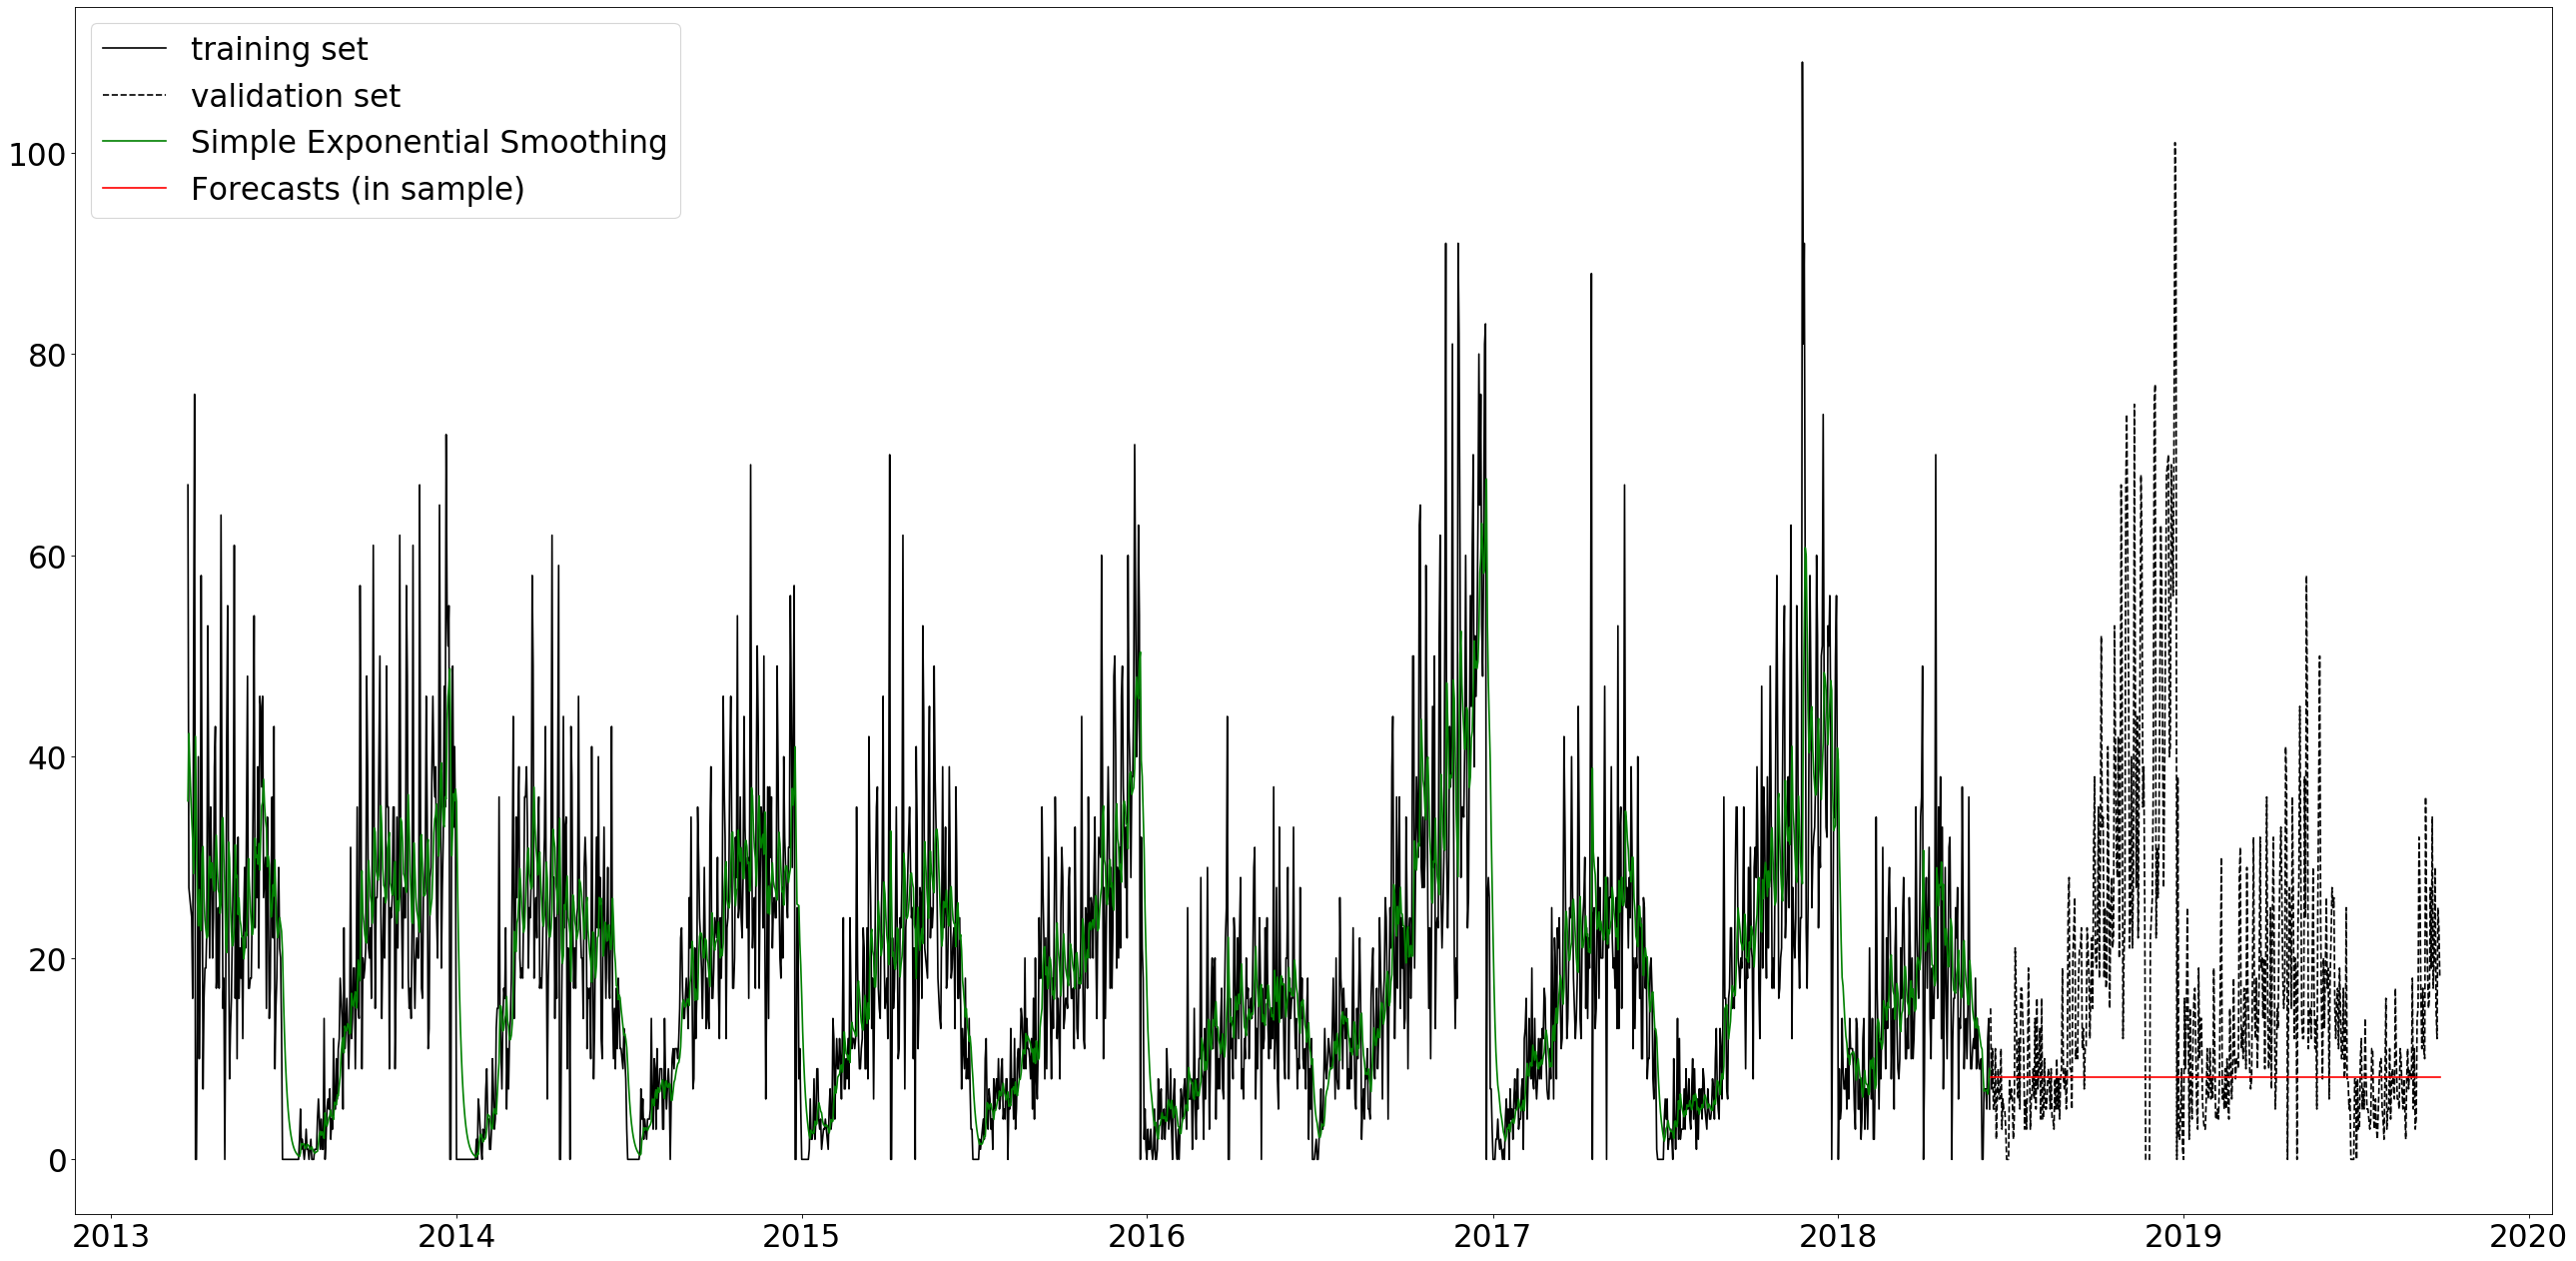

In [16]:
np.warnings.filterwarnings('ignore')

# Applico il modello simple exponential smoothing

modelv1 = SimpleExpSmoothing(train)

# fit del modello
# è possibile passare un parametro smoothing_level di tipo float per fissare una determinata alpha

fitted = modelv1.fit()

# ottengo le previsioni. Stesso periodo del validation set!

forecasted = fitted.forecast(steps = int(len(valid)))

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(fitted.fittedvalues, label="Simple Exponential Smoothing", color=MRC)
plt.plot(forecasted, label="Forecasts (in sample)", color=FC)
plt.legend(loc='best')
plt.plot()

errore = forecasted - valid
errore.dropna(inplace=True)

mse = mean_squared_error(valid, forecasted)
print('MSE: %f' % mse)
print("Calcoliamo  MAE=%.4f"%(sum(abs(errore))/len(errore)))

### Triple Exponential Smoothing

Questo metodo è conosciuto anche come metodo "Holt-Winters"

MSE: 323.875783
Calcoliamo  MAE=13.1073


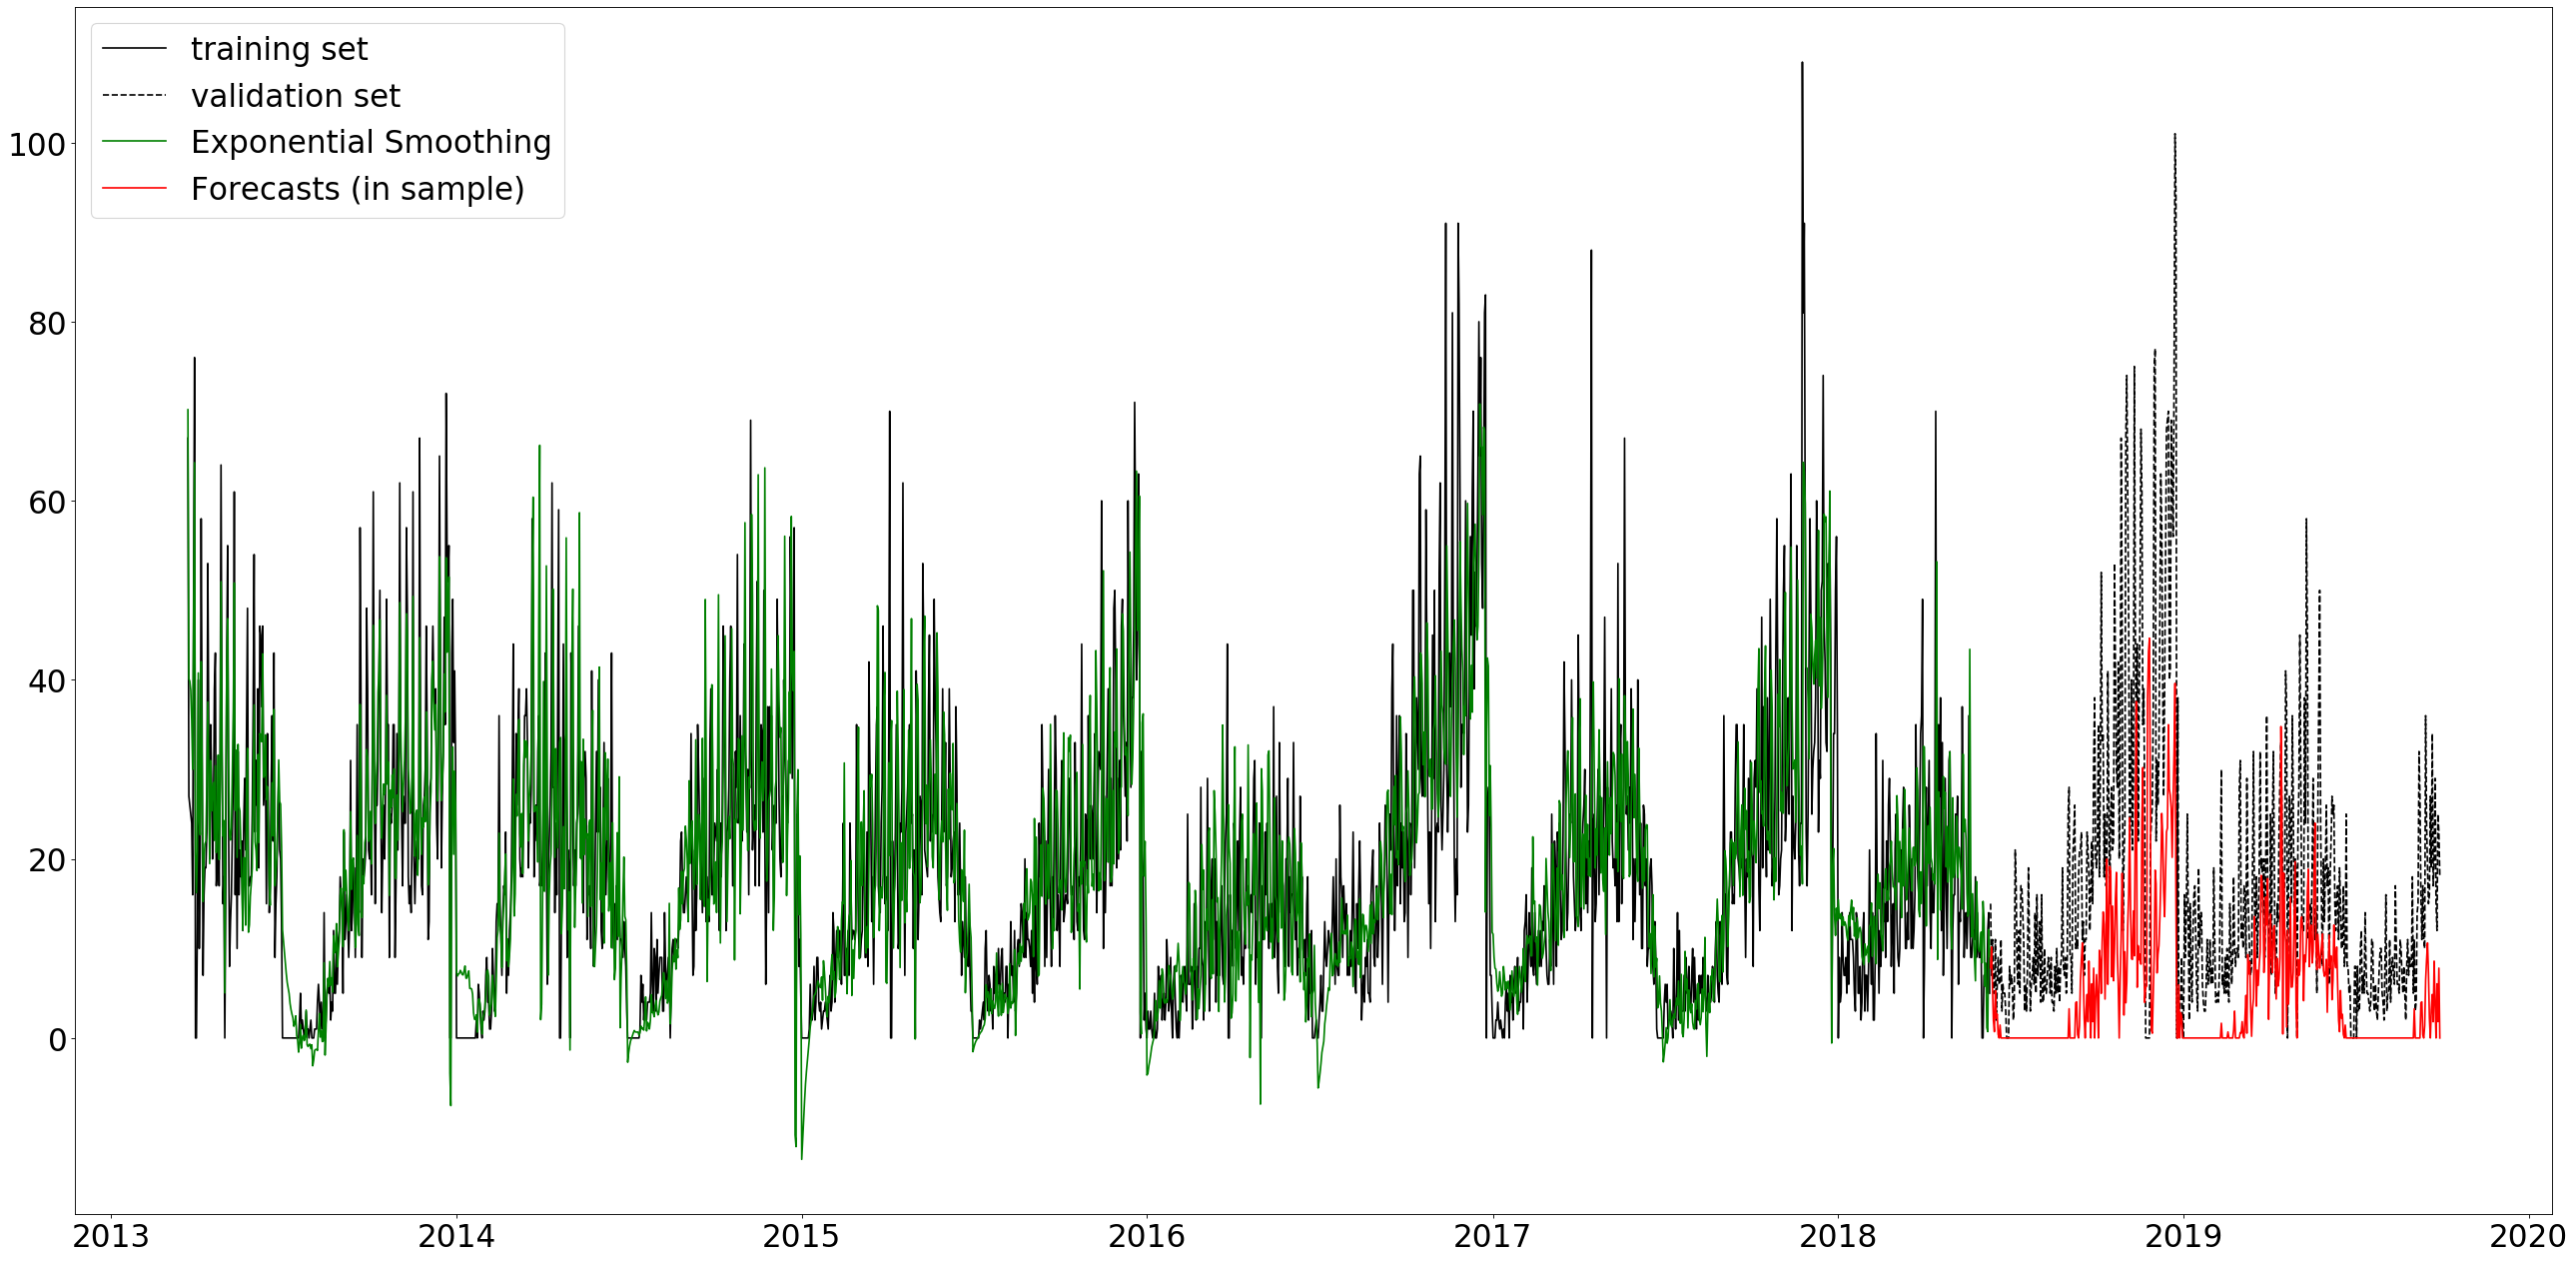

In [15]:
np.warnings.filterwarnings('ignore')
model = ExponentialSmoothing(train, trend="additive", damped = False, seasonal="additive", seasonal_periods=year)

# Fit del modello

fitted = model.fit()

# Eseguo le previsioni

model_predictions = fitted.forecast(steps = int(len(valid)))

# tolgo i valori negativi dalle previsioni

for i in range(1, len(model_predictions)):
    if model_predictions[i] < 0:
        model_predictions[i] = 0

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(fitted.fittedvalues, label="Exponential Smoothing", color=MRC)
plt.plot(model_predictions, label="Forecasts (in sample)", color=FC)
plt.legend(loc='best')
plt.plot()

errore = model_predictions - valid
errore.dropna(inplace=True)

mse = mean_squared_error(valid, model_predictions)
print('MSE: %f' % mse)
print("Calcoliamo  MAE=%.4f"%(sum(abs(errore))/len(errore)))

### Exponential Smoothing con decomposizione

MSE: 158.246838
Calcoliamo  MAE=8.4754


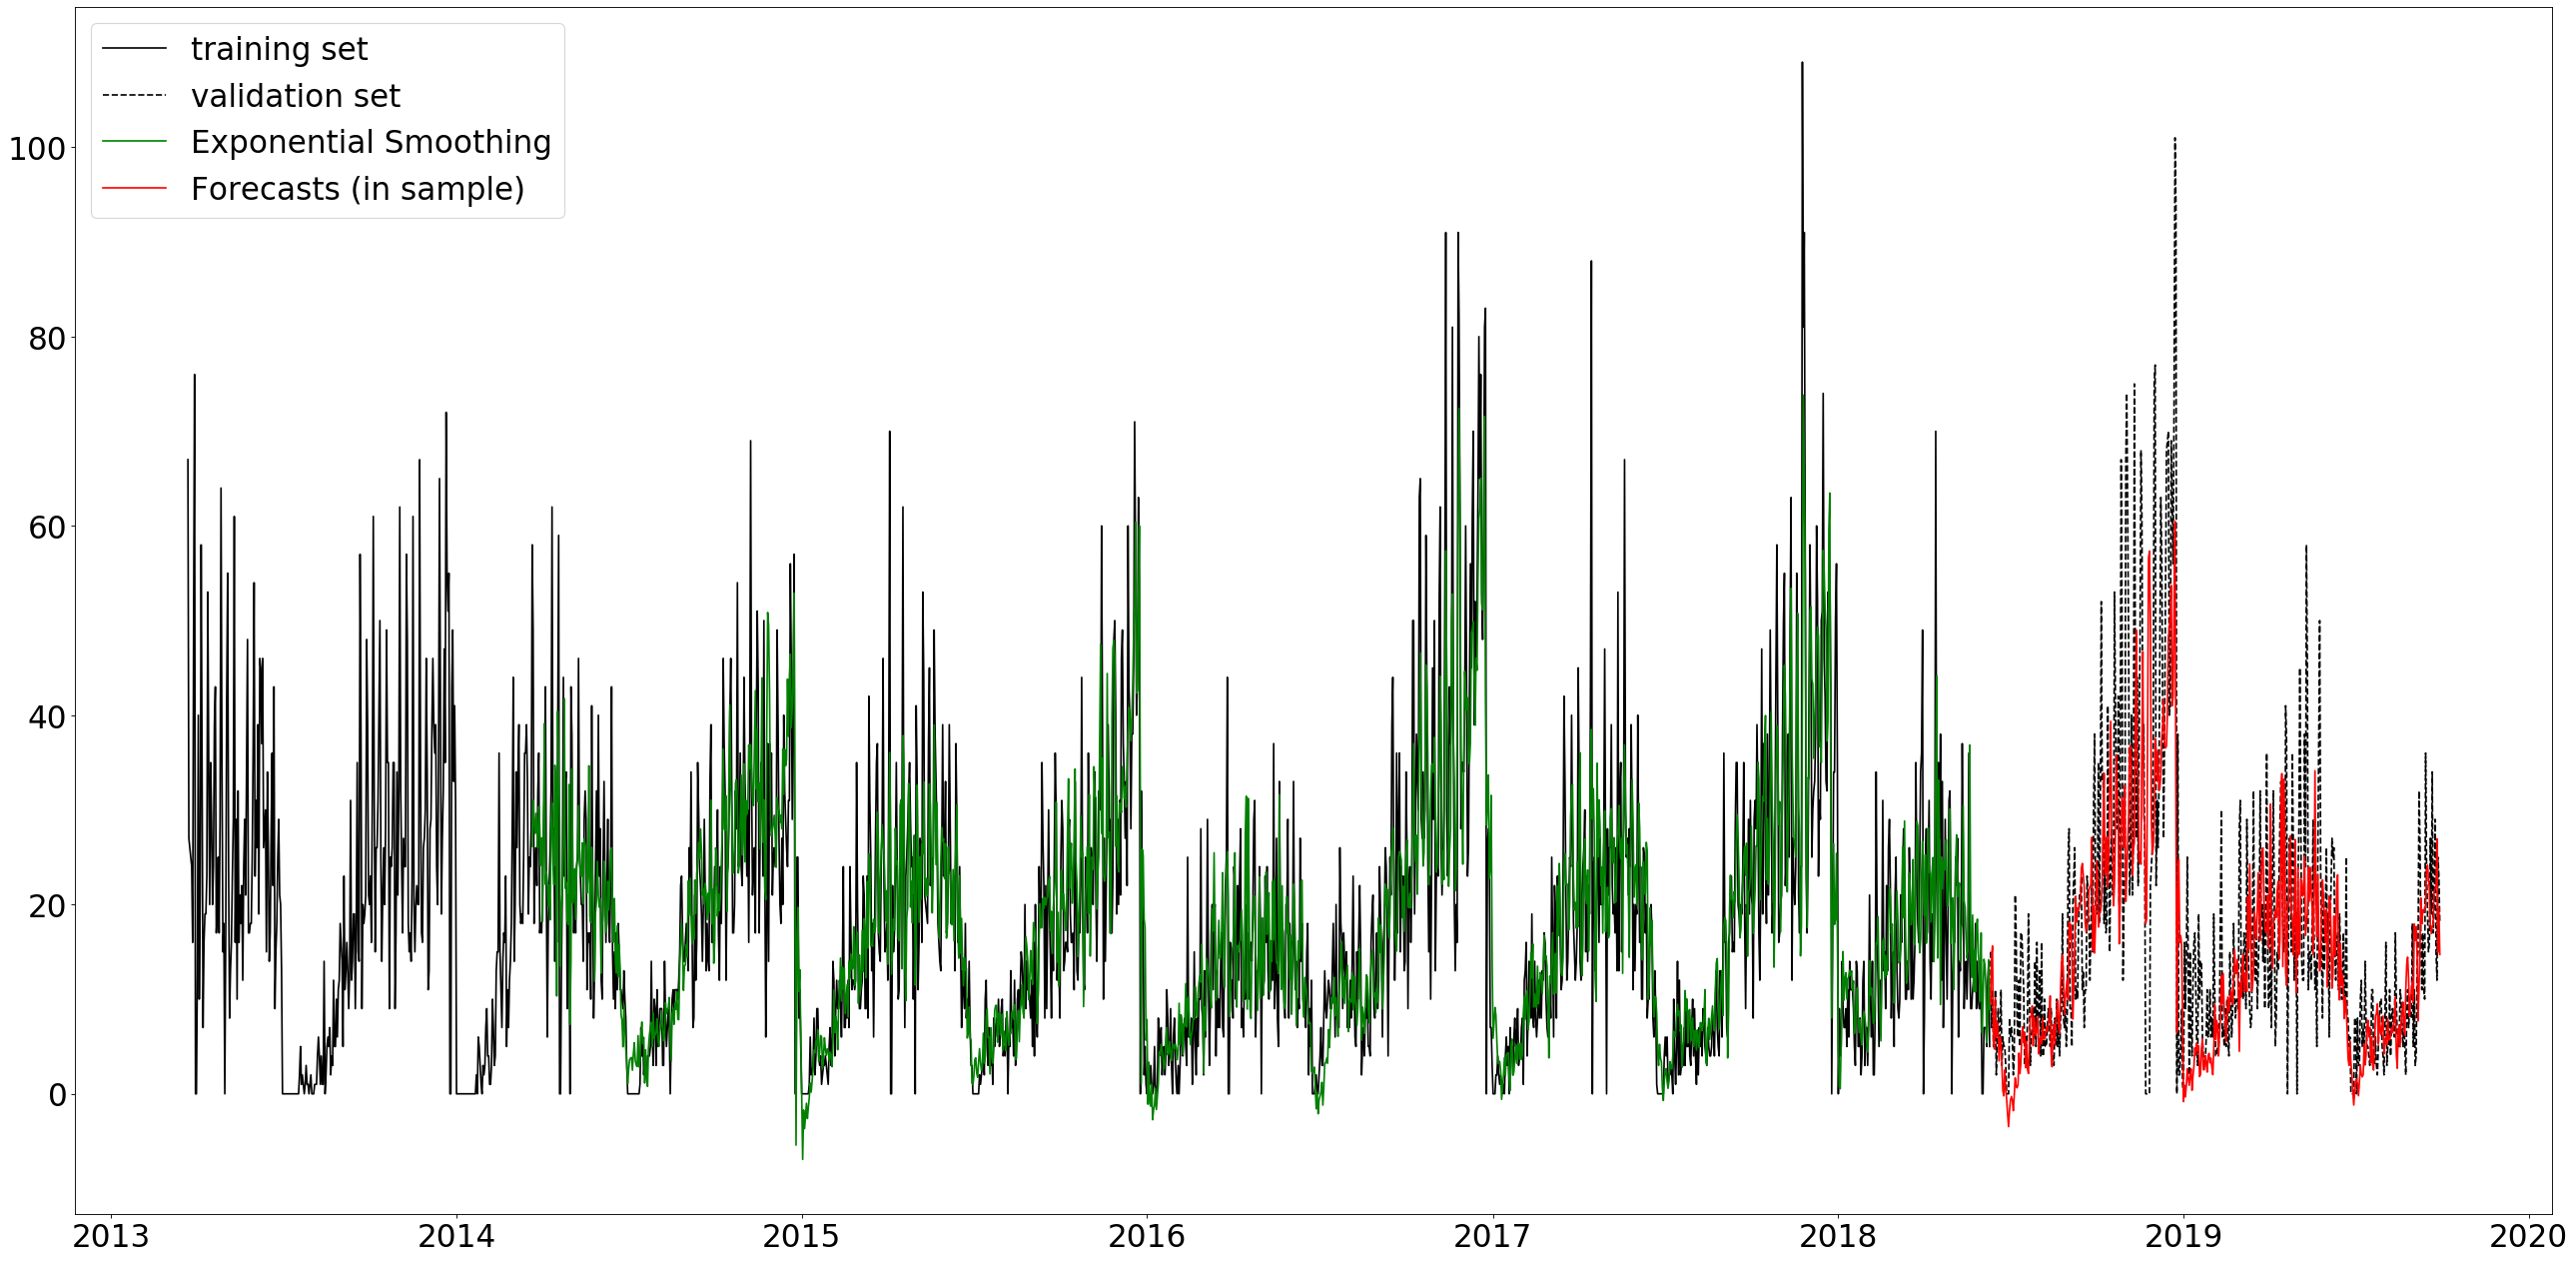

In [14]:
# %%
# Proviamo a usare ets in maniera scomposta sulle componenti e poi
# sommare i risultati.
#
# NOTA: qua sommare i residual è di poco conto.
np.warnings.filterwarnings('ignore')
decomposition = seasonal_decompose(train, period=year, two_sided=False)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend.dropna(inplace=True)
seasonal.dropna(inplace=True)
residual.dropna(inplace=True)

# Creiamo dei modelli per trend e seasonal + USO ARIMA PER I RESIDUAL VISTO CHE SONO UNA COMPONENTE STAZIONARIA
trend_model = ExponentialSmoothing(trend, trend="add", damped = True, seasonal=None)
seasonal_model = ExponentialSmoothing(seasonal, trend=None, seasonal='add', seasonal_periods=year)

# ARIMA SU RESIDUAL (PER FORZA)
residual_model = ARIMA(residual, order=(1, 0, 6))

# fit model
trend_fitted    = trend_model.fit()
seasonal_fitted = seasonal_model.fit()
residual_fitted = residual_model.fit()

# make prediction. Stesso periodo del validation set!    
trend_model_predictions = trend_fitted.forecast(steps = int(len(valid)))
seasonal_model_predictions = seasonal_fitted.forecast(steps = int(len(valid)))
residual_model_predictions, _, _ = residual_fitted.forecast(steps = int(len(valid)))

#Sommo i modelli
model_predictions = trend_model_predictions \
                    + seasonal_model_predictions \
                    + residual_model_predictions

model_predictions.dropna(inplace=True)

# annulliamo i valori negativi

plt.figure(figsize=(40, 20), dpi=80)
plt.plot(train, label="training set", color=TSC)
plt.plot(valid, label="validation set", color =VSC, linestyle = '--')
plt.plot(trend_fitted.fittedvalues + 
         seasonal_fitted.fittedvalues + 
         residual_fitted.fittedvalues, label="Exponential Smoothing", color=MRC)
plt.plot(model_predictions, label="Forecasts (in sample)", color=FC)
plt.legend(loc='best')
plt.plot()


errore = model_predictions - valid
errore.dropna(inplace=True)

mse = mean_squared_error(valid, model_predictions)
print('MSE: %f' % mse)
print("Calcoliamo  MAE=%.4f"%(sum(abs(errore))/len(errore)))

## Bibliografia

- Test Dickey-Fuller: https://otexts.com/fpp3/stationarity.html
- Exponential Smoothing: https://otexts.com/fpp2/ses.html
- Triple Exponential Smoothing: https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/